In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.01
c_reg2=0.0001
d=2

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.664173698289076>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.1565367575795712>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.4210840326548553>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.35837820225292316>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([1.05177988, 2.32201004, 1.19092699, 1.50375018, 3.15206333,
       2.23825143, 1.45301251, 0.91485176, 4.38645211, 3.44910696])>


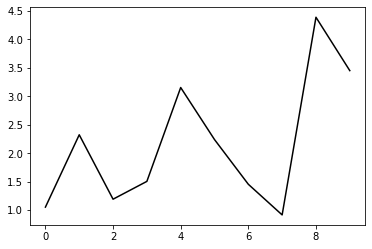

In [40]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


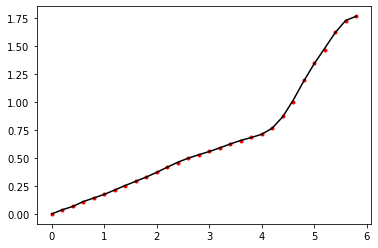

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

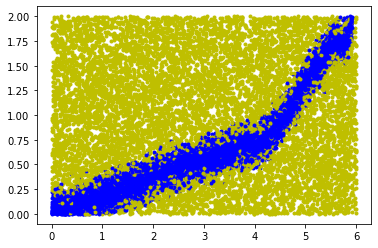

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [41]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

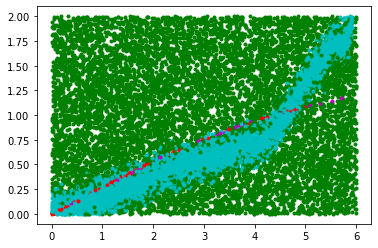

In [42]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [31]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [32]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.1203895831848816, shape=(), dtype=float64)
tf.Tensor(1.1294722007165265, shape=(), dtype=float64)
tf.Tensor(1.1094499517683656, shape=(), dtype=float64)
tf.Tensor(1.099486229130089, shape=(), dtype=float64)
tf.Tensor(1.0994513762729792, shape=(), dtype=float64)
tf.Tensor(1.1172339900090484, shape=(), dtype=float64)
tf.Tensor(1.1193403575474237, shape=(), dtype=float64)
tf.Tensor(1.1191235917667177, shape=(), dtype=float64)
tf.Tensor(1.1094514103254847, shape=(), dtype=float64)
tf.Tensor(1.1394321772222327, shape=(), dtype=float64)
tf.Tensor(1.109449490171756, shape=(), dtype=float64)
tf.Tensor(1.0894518602678445, shape=(), dtype=float64)
tf.Tensor(1.129418419397655, shape=(), dtype=float64)
tf.Tensor(1.1291693797119327, shape=(), dtype=float64)
tf.Tensor(1.1294504726615688, shape=(), dtype=float64)
tf.Tensor(1.0996754532970276, shape=(), dtype=float64)
tf.Tensor(1.1063094988545463, shape=(), dtype=float64)
tf.Tensor(1.1394125872085585, shape=(), dtype=float64)
tf.Tensor(1.1

# Optimize

0 1.0334853611175492
1.6725375584698745 0.14817288402814302 -0.4294479070394412 -0.35001432670784566
[1.00177988 2.3720098  1.24092679 1.55374985 3.20206254 2.28825061
 1.50301133 0.96484995 4.4364463  3.49908485]


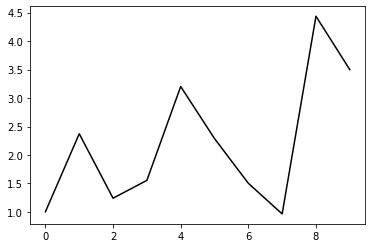

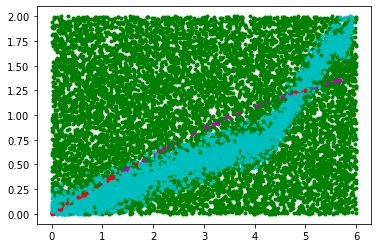

1000 0.987317422789661
1.7009296470171469 0.08102246112729573 -0.4035958669607002 -0.3439008644012251
[1.37584356 0.92510994 1.04058026 1.27554691 1.55525163 1.50181077
 0.99299468 0.49994583 2.29640889 7.83623769]


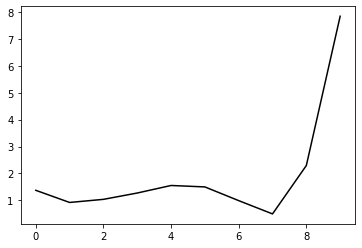

2000 0.9299460870599711
1.6339091760715478 0.10793462321917836 -0.36554040016826916 -0.3632772840420634
[ 1.28739469  1.13875794  1.07862007  1.15012155  1.22630106  1.05685966
  0.40848118 -0.55467296 -0.17700812  8.56800358]


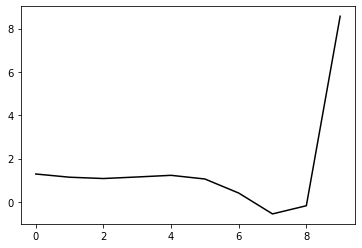

3000 0.6297931374556535
1.5390515153383437 0.1267074888977558 -0.3750500071504074 -0.3245506062071747
[ 1.03007402  1.16761138  1.09324298  0.98557817  0.78952312  0.33924026
 -0.64604213 -2.25773156 -3.1474439   8.1895803 ]


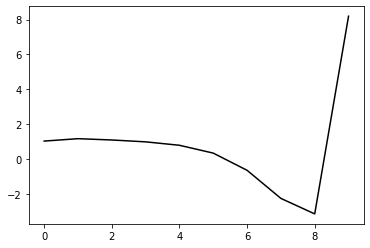

4000 0.3460648081441677
1.3882660804887152 0.03285712761614384 -0.35541777051303286 -0.23786798742547502
[ 0.99517755  0.90653971  0.7206866   0.4390187   0.01098916 -0.70920019
 -2.01553742 -4.14025989 -5.98201044  7.7912858 ]


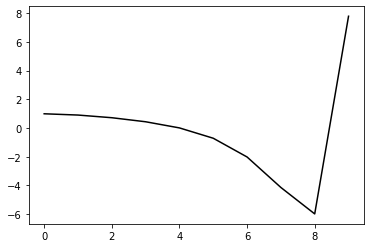

5000 0.2645485605629451
1.3253256092511725 -0.11129857332833815 -0.35041440549366515 -0.22257349911409496
[ 0.98473673  0.91386441  0.74215348  0.45084018 -0.01125024 -0.77154871
 -2.10799299 -4.32033006 -6.43948363  7.75766278]


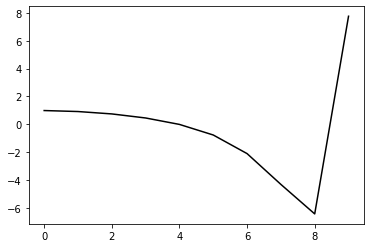

6000 0.19910251295675044
1.2971365171035816 -0.18765880316382216 -0.3577790191778014 -0.2580885624084749
[ 1.08363725  1.04588102  0.91665306  0.6816116   0.27697981 -0.42566444
 -1.68413139 -3.81277792 -5.84248738  7.77383937]


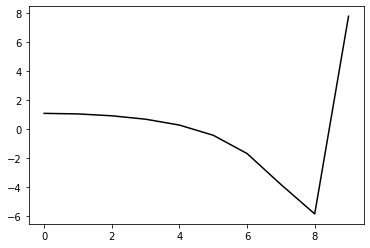

7000 0.14523137398035016
1.2777541992771073 -0.18710383477840262 -0.3556673986902966 -0.2479832033670315
[ 1.1280935   1.06078496  0.94656072  0.7315117   0.34400998 -0.34318564
 -1.57715051 -3.69032833 -5.78854407  7.78864196]


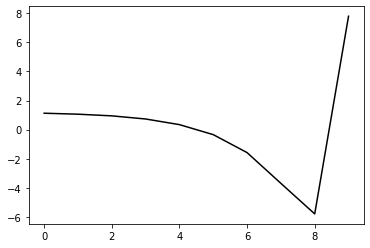

8000 0.2912081522806532
1.250036209542181 -0.1876584216353972 -0.34998058491253564 -0.242179362723752
[ 1.1529028   1.0837662   0.98442376  0.78671118  0.4172857  -0.25350949
 -1.46928298 -3.58122229 -5.79973893  7.83140216]


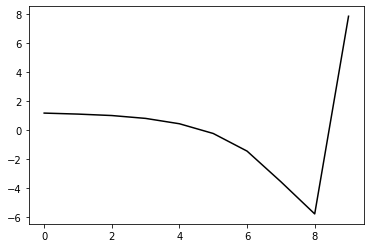

9000 0.18448673718190134
1.2428807555134278 -0.1781901649351088 -0.3423656203489631 -0.2343933385954835
[ 1.12369778  1.13780431  1.05098097  0.85882836  0.49659452 -0.16391012
 -1.36474645 -3.46830546 -5.75549599  7.78616106]


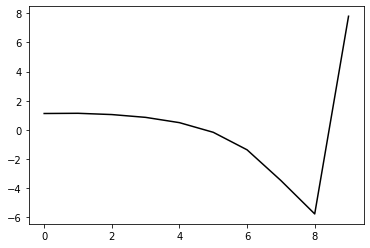

10000 0.24338055087744567
1.2053519525361767 -0.18573344611818748 -0.3398791131855843 -0.23072538624652505
[ 1.16889059  1.14164158  1.07120432  0.89949103  0.55817389 -0.08100807
 -1.25967403 -3.35250607 -5.72808593  7.83856873]


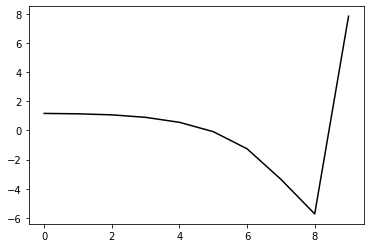

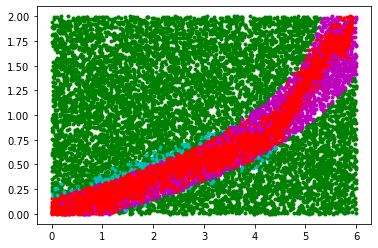

11000 0.2199818038654212
1.19637766305538 -0.17853145885134758 -0.33363380777353074 -0.2266985982297118
[ 1.1839111   1.17137784  1.11264798  0.95653751  0.63509211  0.01989219
 -1.13031026 -3.19760535 -5.61369889  7.81870792]


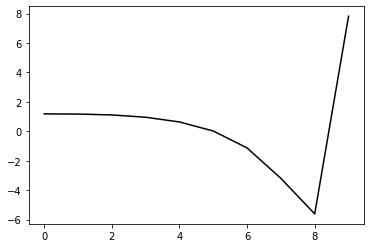

12000 0.17191457519210046
1.1506900030259433 -0.18505322156935242 -0.32999427384755425 -0.22116783539543464
[ 1.17731759  1.20843038  1.16215938  1.01839316  0.70971196  0.10829572
 -1.02966836 -3.10181832 -5.64570694  7.84336514]


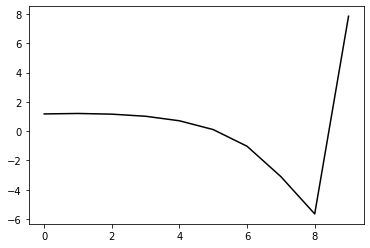

13000 0.22766570954077653
1.1355795648423403 -0.17918494354490896 -0.3248511828035151 -0.2156859406520739
[ 1.20400559  1.20210744  1.16842846  1.04422341  0.75926379  0.18498078
 -0.92335505 -2.97521933 -5.59317242  7.8380012 ]


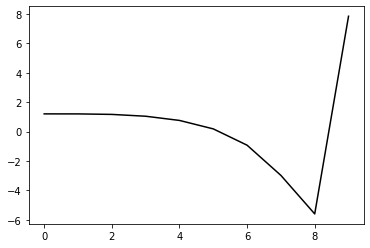

14000 0.19165875895999798
1.0934451156937033 -0.18268331038920987 -0.31809755353464514 -0.21227121230339197
[ 1.19148604  1.21883973  1.19087991  1.06742182  0.78406344  0.21238653
 -0.89763031 -2.97507302 -5.74241422  7.79271139]


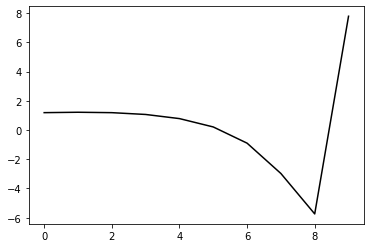

15000 0.2972840876730126
1.0793616038408897 -0.1753699423364688 -0.3125320781537413 -0.211834286409076
[ 1.22778791  1.1995082   1.18736574  1.09776322  0.85502149  0.32984824
 -0.7268583  -2.75330648 -5.53249244  7.88363535]


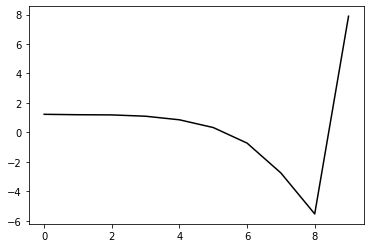

16000 0.23275736669732658
1.0307837549191008 -0.18055629824790478 -0.311013789650716 -0.2027839431936604
[ 1.23076763  1.20092192  1.19060818  1.10877977  0.88576622  0.38944279
 -0.63552919 -2.64573294 -5.53529765  7.84747721]


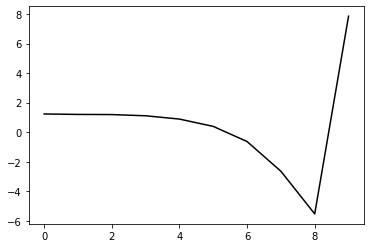

17000 0.18232344708706993
1.0078520785680816 -0.17072375132965797 -0.3014170105640065 -0.19791264815028353
[ 1.19017762  1.27178409  1.25621148  1.16554973  0.94225526  0.45684111
 -0.551054   -2.55705789 -5.55154831  7.84622401]


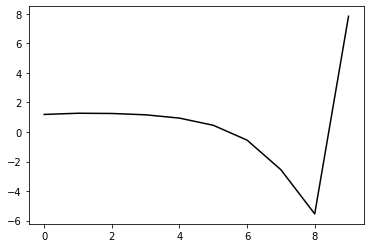

18000 0.2290293874756054
0.972252236050366 -0.17153634650816318 -0.2978154411295446 -0.1939304485920151
[ 1.18202216  1.28194471  1.27525899  1.19942319  0.99211711  0.5295402
 -0.44715181 -2.43054643 -5.49229637  7.88680557]


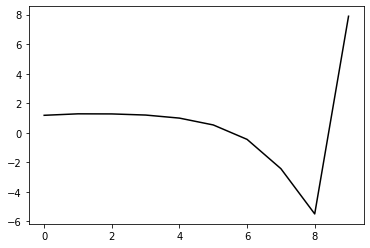

19000 0.23018197076818736
0.9420482668557241 -0.16852964926456301 -0.29261880459276746 -0.19526937180239967
[ 1.20934416  1.29724725  1.30930432  1.25096783  1.06659804  0.63439775
 -0.30417383 -2.25739787 -5.38692093  7.89291632]


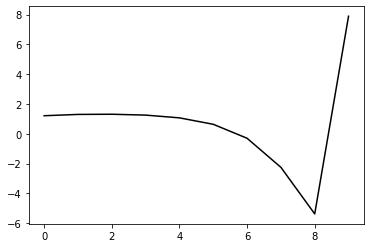

20000 0.23517688055965066
0.8949168696024715 -0.17168004052593683 -0.28976004258683896 -0.19294973546051372
[ 1.24782602  1.27606031  1.29360286  1.24772112  1.07972074  0.67025313
 -0.23740087 -2.16311341 -5.34777046  7.84908144]


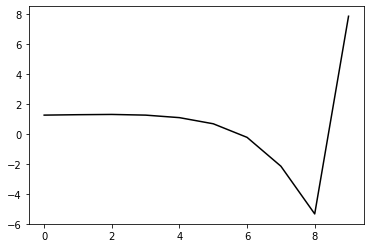

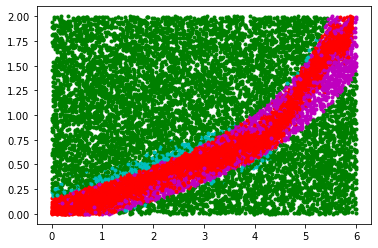

21000 0.1764331723569653
0.8588303445736181 -0.169304312887901 -0.2866729281576391 -0.1887141634685191
[ 1.25733877  1.2896668   1.3228376   1.29566039  1.15140518  0.77168183
 -0.09869209 -1.98821641 -5.20788385  7.90645611]


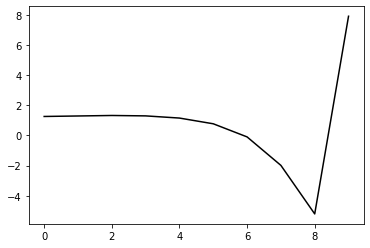

22000 0.16464816184910738
0.8173860170586028 -0.17096820072386265 -0.2831854855110701 -0.18238495638557206
[ 1.24811763  1.30146891  1.33101213  1.30194473  1.15741634  0.77776161
 -0.09616058 -2.01398695 -5.38803301  7.85968075]


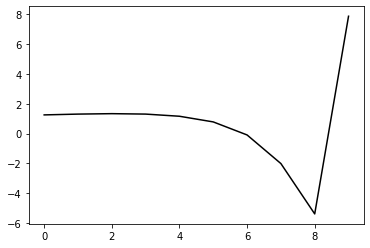

23000 0.14935448822510575
0.7835352428969633 -0.17091574111354008 -0.2788906919174524 -0.18496705872668445
[ 1.22337164  1.34597697  1.3829838   1.36497843  1.2365541   0.88051691
  0.03934394 -1.84562986 -5.26623159  7.90514089]


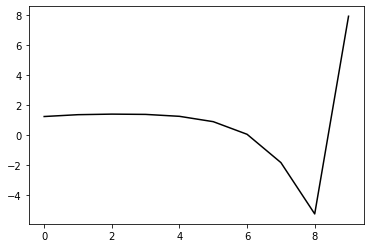

24000 0.19070333306423257
0.7511359732961996 -0.16693844877539865 -0.2749360685472305 -0.18214669860924237
[ 1.26366493  1.29858432  1.35951704  1.36108625  1.25426725  0.92604964
  0.11991531 -1.73017379 -5.18313836  7.90651746]


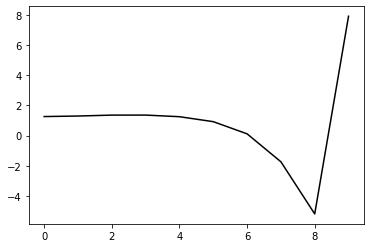

25000 0.3054029111872637
0.7101786598151215 -0.16827734959261098 -0.27425161780914525 -0.17726867961933568
[ 1.2160289   1.32803942  1.37790857  1.38265958  1.28864033  0.98113863
  0.20508116 -1.61098231 -5.09612767  7.91548089]


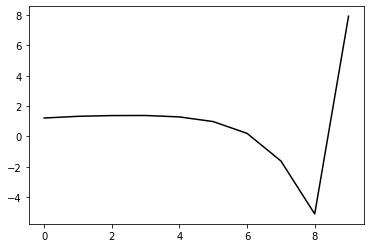

26000 0.16155363296432435
0.6814144163479808 -0.1622189796071954 -0.26907378859237274 -0.17412306516098117
[ 1.24206377  1.31766289  1.36998781  1.37741949  1.2865298   0.99080828
  0.23853027 -1.54800182 -5.07060777  7.88676023]


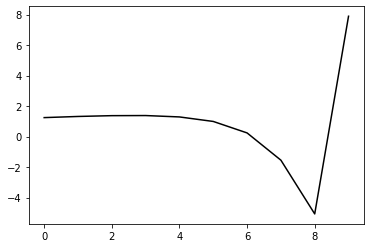

27000 0.21648661030365368
0.6367050351107925 -0.16256604817709694 -0.2683035703982012 -0.1715301533306426
[ 1.24960736  1.32915426  1.37790874  1.3944078   1.32072112  1.04562702
  0.3203619  -1.43406498 -4.97048152  7.91136361]


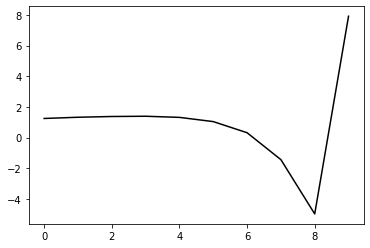

28000 0.21602338623286735
0.6138891454289812 -0.157824831241691 -0.264204719949058 -0.16983040431453383
[ 1.25355525  1.33336442  1.40180836  1.42881412  1.36352961  1.10202963
  0.39850223 -1.32913421 -4.88658337  7.88904784]


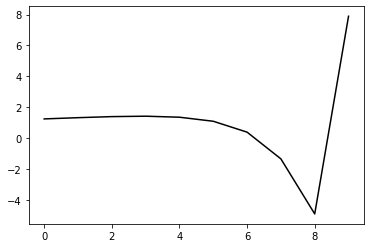

29000 0.19755724280727555
0.580900302322643 -0.16152647491871308 -0.262921155997223 -0.16956539877733354
[ 1.25077114  1.32141775  1.39812313  1.42908758  1.36416737  1.10216999
  0.40351255 -1.31124082 -4.88931918  7.91527257]


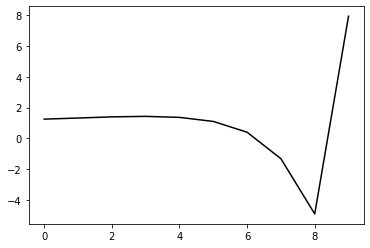

30000 0.16935509720344982
0.5623034970773224 -0.1561632759812619 -0.26014794916128864 -0.16407337939279812
[ 1.25202605  1.30550154  1.37125922  1.41183195  1.36584746  1.12474826
  0.45021669 -1.23310053 -4.81075222  7.94314193]


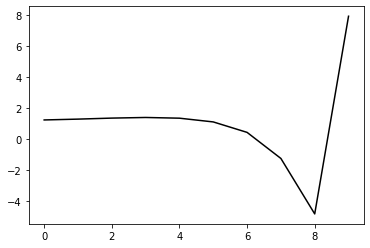

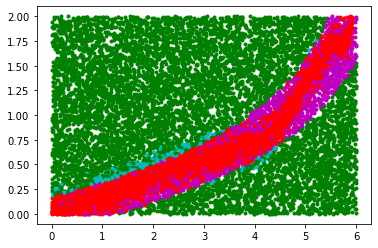

31000 0.19518437204582206
0.5463890022803969 -0.15004596118722535 -0.2558670720744643 -0.16163867816218827
[ 1.19285766  1.35355687  1.42239043  1.44926892  1.3990931   1.17344037
  0.53290929 -1.09843839 -4.63880466  7.98675376]


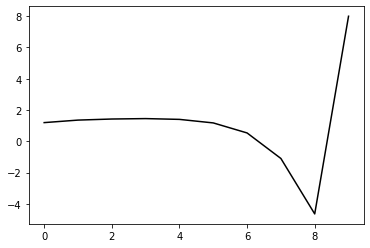

32000 0.17671977634920757
0.5089786325607905 -0.15824728558608048 -0.25661027570353806 -0.16615629934883525
[ 1.22931592  1.33806361  1.41674743  1.44906291  1.39531617  1.16146549
  0.51996649 -1.09860699 -4.63504444  7.97565537]


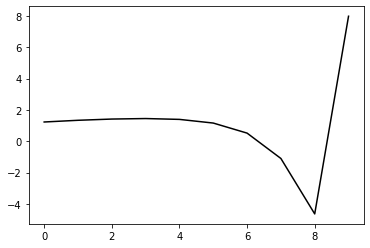

33000 0.2461930548282899
0.503361810679717 -0.1476256257662844 -0.24992743935650283 -0.16425324832535926
[ 1.22158821  1.31686886  1.38906195  1.42985176  1.38599121  1.16006604
  0.52857895 -1.06879166 -4.59563205  7.9587277 ]


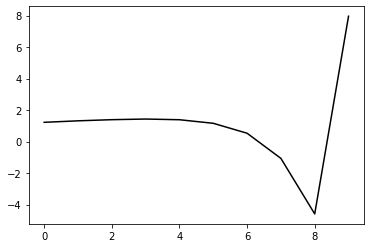

34000 0.19720004429620983
0.4764625854040912 -0.15439183337037596 -0.25194340590487496 -0.16483784935231335
[ 1.20895379  1.32056851  1.418888    1.47169038  1.43228818  1.20787078
  0.57554502 -1.01970403 -4.5530481   7.95705657]


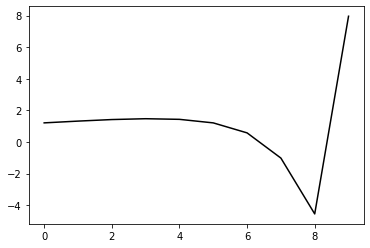

35000 0.27535349070394305
0.4552787716369428 -0.1556461909974295 -0.2514106889776292 -0.16448761022445746
[ 1.20201465  1.31077231  1.39378158  1.44474622  1.41935033  1.21621675
  0.60880534 -0.95513127 -4.45895137  8.02258471]


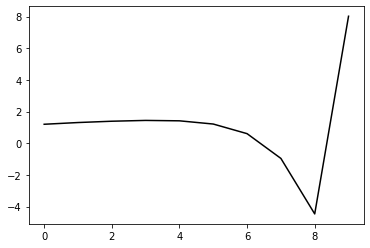

36000 0.2667426873216749
0.44162172190143795 -0.152270596653404 -0.24974938874195646 -0.1613868765216311
[ 1.19791008  1.28602183  1.34372966  1.38722114  1.36768741  1.18326516
  0.60699814 -0.91729071 -4.38364034  7.99900099]


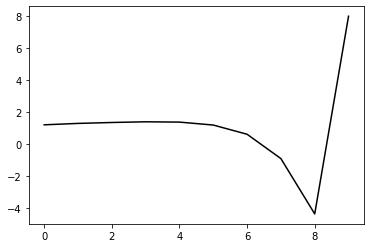

37000 0.20504056971909834
0.4267155185679641 -0.15374193478217807 -0.24954757213953035 -0.16202920986526204
[ 1.19312657  1.29840201  1.37588918  1.41891041  1.38843907  1.19670169
  0.62665235 -0.87304949 -4.30093822  8.00858269]


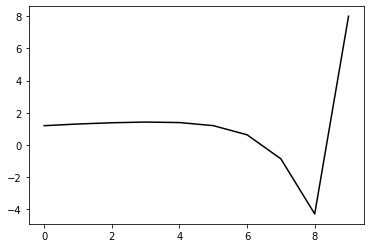

38000 0.1411021324586345
0.4159025920120206 -0.15077306409296562 -0.24857484623068388 -0.1570017030023129
[ 1.20346199  1.30985014  1.38537589  1.43074023  1.40663073  1.22200666
  0.66519116 -0.80360931 -4.18407112  8.03043194]


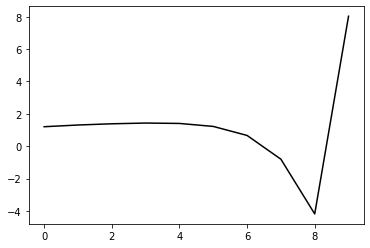

39000 0.13590897440908517
0.4072912669801223 -0.14747549083397013 -0.24605012338074148 -0.15363623613996352
[ 1.17929723  1.25347472  1.30753282  1.33310122  1.28891745  1.09387384
  0.54291487 -0.894714   -4.21588948  8.02713062]


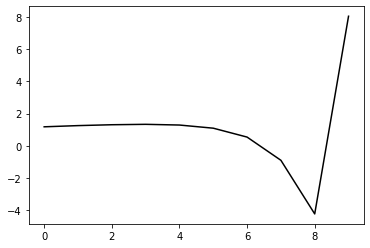

40000 0.2895960684362004
0.40001188426374007 -0.14611478638324196 -0.24357625151443058 -0.15413476246018018
[ 1.13749774  1.30859997  1.33127418  1.33526928  1.28012906  1.077209
  0.52619211 -0.88970311 -4.15784681  8.01626787]


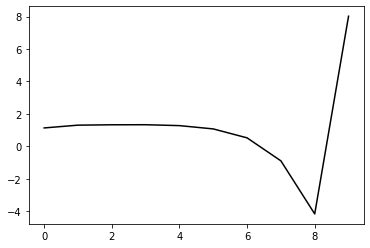

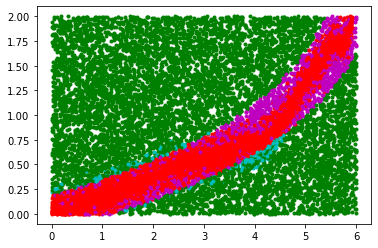

41000 0.23591041889850917
0.38398407235959026 -0.1508560256343074 -0.24387684251805514 -0.16096861257736667
[ 1.15636164  1.26442961  1.32446517  1.34792979  1.2991357   1.09869017
  0.55777069 -0.82745785 -4.02810753  8.08990895]


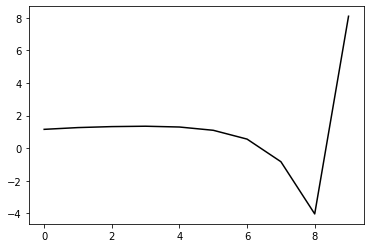

42000 0.14289170328661363
0.3809358568405664 -0.14796359558587016 -0.24347165273773008 -0.15484502158598548
[ 1.1619908   1.2440422   1.3018187   1.33310272  1.29680544  1.10566303
  0.57196797 -0.79065684 -3.93197797  8.0645221 ]


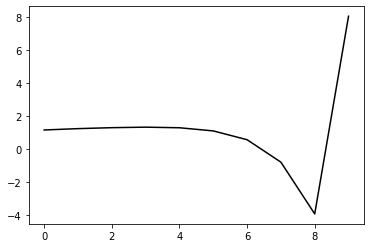

43000 0.2042914222079545
0.36836172498462677 -0.14697596049044506 -0.24049407382673077 -0.15568421248199862
[ 1.13370398  1.20943763  1.24962412  1.27010527  1.21955289  1.01772858
  0.47936895 -0.87336908 -3.96634575  8.03972243]


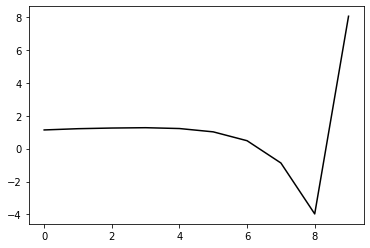

44000 0.23451060499819942
0.35849406078821244 -0.15122029781616042 -0.2419618968537899 -0.15846703297110357
[ 1.14182077  1.2317342   1.29700781  1.32887621  1.29276231  1.10512674
  0.58091429 -0.74722857 -3.77484375  8.07971481]


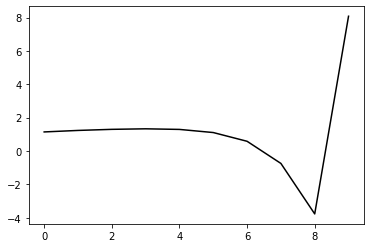

45000 0.2360556015209269
0.3510699404234527 -0.15505818446528136 -0.24509232114957366 -0.15378607007186862
[ 1.10970878  1.16850079  1.20265198  1.22226973  1.18687792  1.01151641
  0.50810944 -0.78645546 -3.73835208  8.10716817]


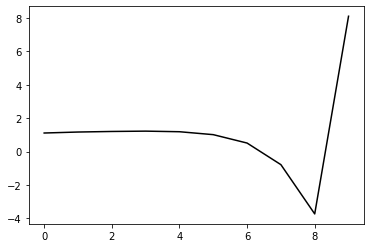

46000 0.23047869431195844
0.34122037943139477 -0.14811203660393588 -0.23907306643792858 -0.15598310328244283
[ 1.11087467  1.19463827  1.21851876  1.22930387  1.18835305  1.01613178
  0.52717907 -0.74373493 -3.64422741  8.10615442]


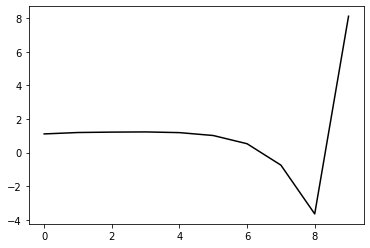

47000 0.2012234356677421
0.34843641248402746 -0.14120232792544718 -0.23590065518021228 -0.15657905213742315
[ 1.08007501  1.27215766  1.32239742  1.32249213  1.25836143  1.06463251
  0.56739405 -0.69165387 -3.54393122  8.12543343]


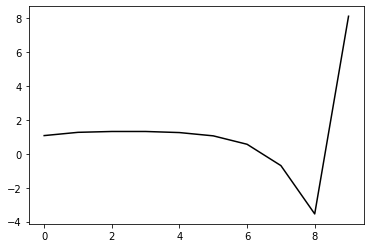

48000 0.20709315016139024
0.33919624300575657 -0.14742817811134534 -0.23707898515331524 -0.15861647306674437
[ 1.09456236  1.20402346  1.24961151  1.25714456  1.20006973  1.00318828
  0.50223066 -0.74014455 -3.53060589  8.13282628]


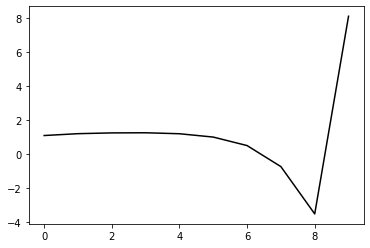

49000 0.19108368364685638
0.3309155928732453 -0.14905205918920947 -0.23724345393774704 -0.16000455790634086
[ 1.10724693  1.16008222  1.19072525  1.19605729  1.14651586  0.9654303
  0.48182736 -0.72808    -3.43692206  8.13715456]


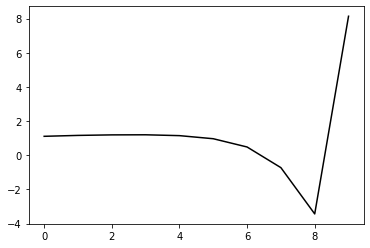

50000 0.18502097568034512
0.3293823320599235 -0.14242055419461588 -0.23379444031584629 -0.15854110176611177
[ 1.11311917  1.16827199  1.20582578  1.20234852  1.13727686  0.94553983
  0.45903583 -0.74249487 -3.40440451  8.1290925 ]


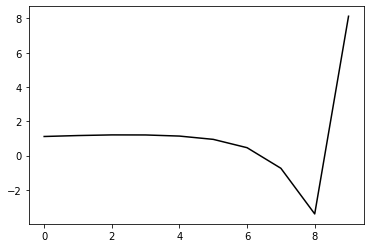

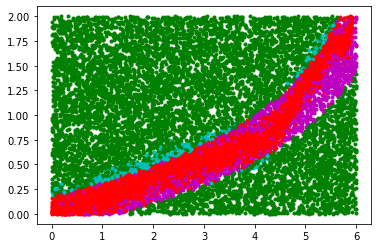

51000 0.22600234778957928
0.32738533818281057 -0.14711030574381945 -0.23682435338550792 -0.15782711503225758
[ 1.09506478  1.15646828  1.18545159  1.1911085   1.14150707  0.96113603
  0.48966063 -0.67893532 -3.25657321  8.1004386 ]


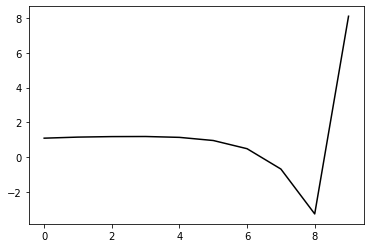

52000 0.2091343322456724
0.3285094272190342 -0.14422016997033588 -0.2367584132975537 -0.15386458566358718
[ 1.0936452   1.20743029  1.22795186  1.22635586  1.17014727  0.98715418
  0.51791382 -0.63713695 -3.16032547  8.16904433]


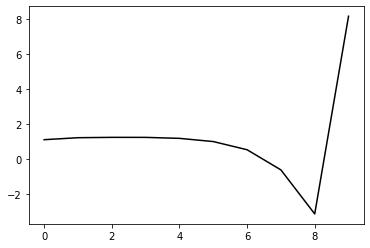

53000 0.12086072175321787
0.3219174790526838 -0.1476893356128258 -0.23698195782518855 -0.1531313191943634
[ 1.11578151  1.15891439  1.17015057  1.16168282  1.09220505  0.8975467
  0.42612309 -0.71296359 -3.17048682  8.16094121]


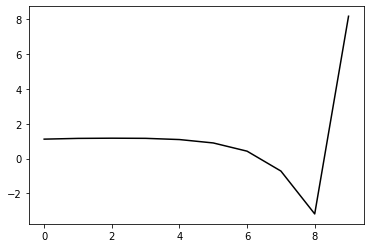

54000 0.15922530148024952
0.31981602003515064 -0.1481115023543674 -0.23659730723335373 -0.1566807692778089
[ 1.1081023   1.1773841   1.20019954  1.19520632  1.12875843  0.93054301
  0.45492873 -0.67061741 -3.06667311  8.19797444]


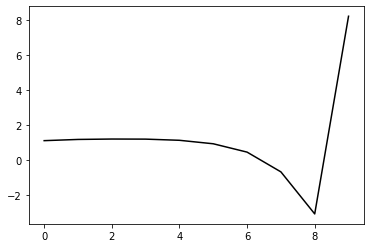

55000 0.20163719020803844
0.3136034356445565 -0.1466888003803194 -0.23639906671693103 -0.15313133776117463
[ 1.10654157  1.17695192  1.20489137  1.20446706  1.14439493  0.95348644
  0.47883408 -0.64397086 -3.00095957  8.18862764]


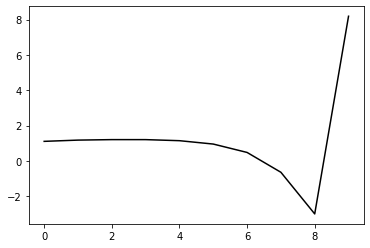

56000 0.17017036194230517
0.31582361007924264 -0.14171621370798157 -0.23385474059006622 -0.15036038630866008
[ 1.08094002  1.19220602  1.19660671  1.18093342  1.11580271  0.92444822
  0.45705544 -0.64694676 -2.9434672   8.18194017]


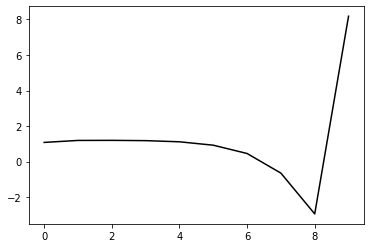

57000 0.24221725895252497
0.3118027958305655 -0.14186746021521898 -0.23337146032354544 -0.15044614984250396
[ 1.09667074  1.1937938   1.21266833  1.20032001  1.12934927  0.93252933
  0.46500396 -0.62785658 -2.86995669  8.18119582]


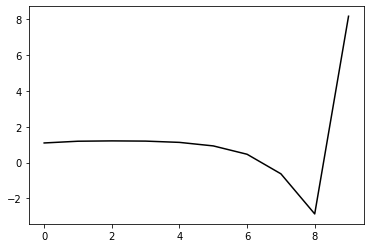

58000 0.29242321645999714
0.31154308198974806 -0.14518647059997622 -0.23479094893249533 -0.1495809345951392
[ 1.08285535  1.18003626  1.21113555  1.19876831  1.10567094  0.87545186
  0.37984395 -0.72090415 -2.92312353  8.19617372]


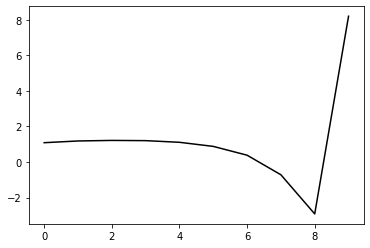

59000 0.15806230517418446
0.30544547789828663 -0.14674470954248955 -0.2342512924372197 -0.15103082020842953
[ 1.08775861  1.15213024  1.17471109  1.17153896  1.09705358  0.87707986
  0.3784677  -0.71727617 -2.86548231  8.19638383]


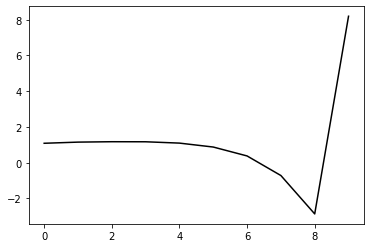

60000 0.18753427917878962
0.2977235465938412 -0.1509295607825301 -0.23691814741181172 -0.1516304741333878
[ 1.08198552  1.13425242  1.15110065  1.14855923  1.09531918  0.91861063
  0.46382291 -0.59379292 -2.6666565   8.26333477]


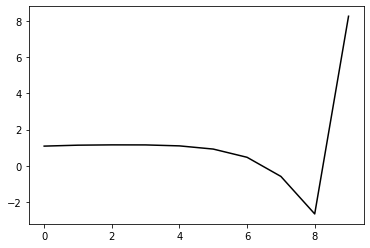

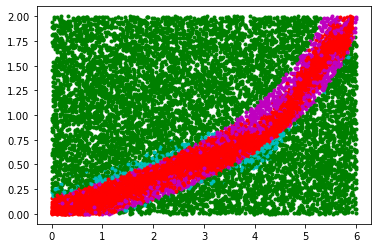

61000 0.20399424884066478
0.29760243161038097 -0.14968787888918275 -0.23446864562494218 -0.15283185820857897
[ 1.07935516  1.17049809  1.1969792   1.17861746  1.09349987  0.88733416
  0.42572904 -0.6232917  -2.65379903  8.23484446]


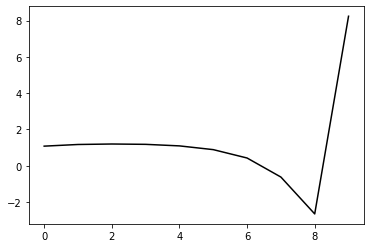

62000 0.27592227788988694
0.3022768592734085 -0.14378896229966875 -0.23176862405884793 -0.1477872560445061
[ 1.08770892  1.13061536  1.16184325  1.1492825   1.06009904  0.83577067
  0.34779782 -0.7168529  -2.73075345  8.23013439]


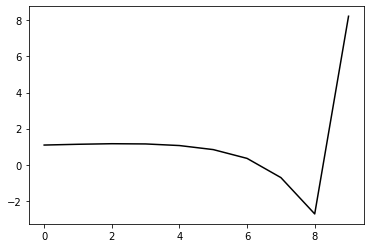

63000 0.1642522087209626
0.300576720299044 -0.14530306210123436 -0.23226925622703964 -0.146522487672093
[ 1.08586217  1.20017838  1.22595431  1.21061144  1.13050912  0.91809171
  0.43356637 -0.62695449 -2.60652061  8.22751295]


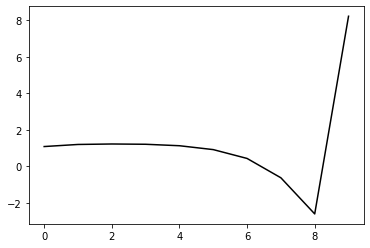

64000 0.17255774395374404
0.2980072389270682 -0.1460323806631605 -0.23161003873166125 -0.14850926997684094
[ 1.10165205  1.19158645  1.22173965  1.20319731  1.11331515  0.8925336
  0.40528447 -0.65269963 -2.601401    8.23713792]


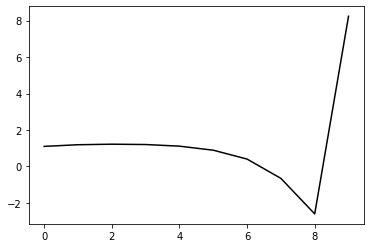

65000 0.2345850621515695
0.2928148956779806 -0.15100257020601737 -0.2360940965871536 -0.1406473177019451
[ 1.07440373  1.13893178  1.12150628  1.08684219  0.99384976  0.77357072
  0.28506813 -0.7719357  -2.6932832   8.25462396]


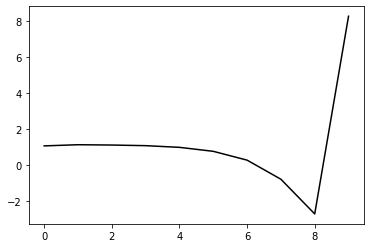

66000 0.2667073397775574
0.2959813046638171 -0.14722341940867095 -0.23115161164912404 -0.15047192732935988
[ 1.09100502  1.16556138  1.21160773  1.20242255  1.1077817   0.8669302
  0.35809133 -0.70649058 -2.59804544  8.24557075]


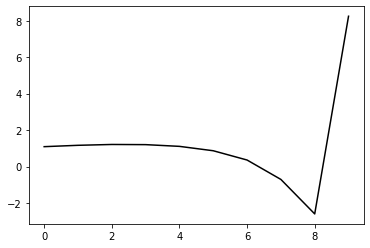

67000 0.19283073715040863
0.3020973001259158 -0.14237513586536063 -0.22928226314982966 -0.14879461712356684
[ 1.09194809  1.16249941  1.21752293  1.21613366  1.12935637  0.88766687
  0.36458054 -0.71288876 -2.58539607  8.24263496]


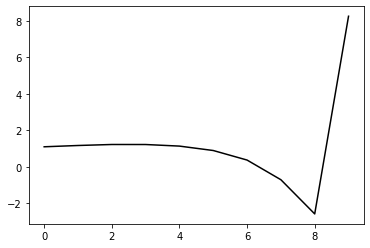

68000 0.2230169609315699
0.2969223651173584 -0.15157417648861904 -0.23199489547354277 -0.15526894323562748
[ 1.07073541  1.15713228  1.18212646  1.15916139  1.06866441  0.84118156
  0.3389165  -0.71438085 -2.52998351  8.25689829]


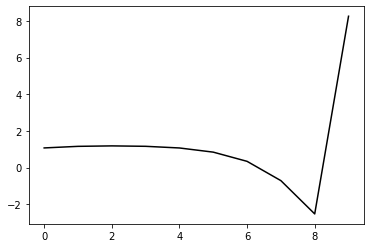

69000 0.22569568340917803
0.29361085279905036 -0.14748882460596333 -0.22936264152140265 -0.15239496260876542
[ 1.07267699  1.06224459  1.0881337   1.07864124  0.99215459  0.7622335
  0.25293532 -0.81479676 -2.63137743  8.23745992]


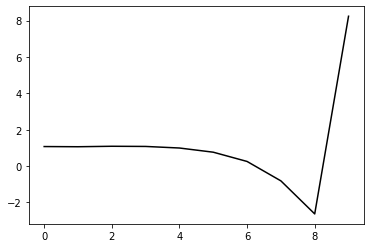

70000 0.15137834745006692
0.29018284400760885 -0.14722618767459364 -0.22728423434939585 -0.15382741103182912
[ 1.0373781   1.09018379  1.08487384  1.06054091  0.9659524   0.73305441
  0.222703   -0.84862665 -2.6553782   8.23764948]


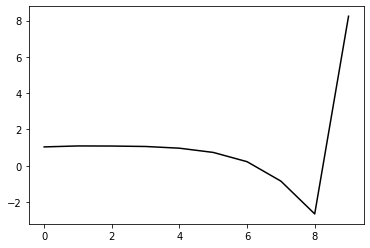

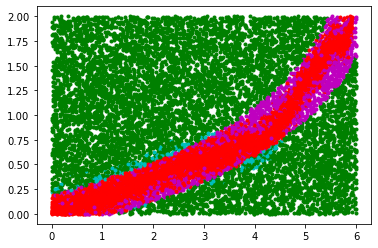

71000 0.14244361042615378
0.2901956444280007 -0.1496165523426875 -0.2289881598099017 -0.15153179291207503
[ 1.04578952  1.13217188  1.15136718  1.12598658  1.0336565   0.81079113
  0.31476052 -0.74265735 -2.52266984  8.25009173]


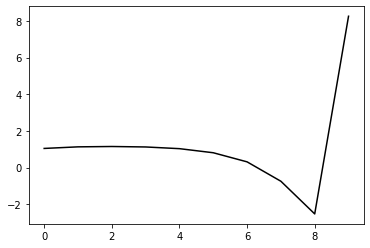

72000 0.17215548678580148
0.28926561004416407 -0.14979460642166353 -0.22847222946599494 -0.15198228964484908
[ 1.07281004  1.08746091  1.09356955  1.07407835  0.99133907  0.77947177
  0.3009215  -0.73362981 -2.47740879  8.25879434]


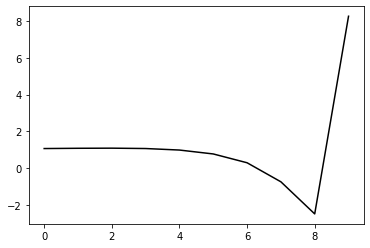

73000 0.13506372190362131
0.28840470343740604 -0.14786643275863312 -0.22767365394884112 -0.1496549603168372
[ 1.07300368  1.11393769  1.13446396  1.13105549  1.05688293  0.84987135
  0.3771595  -0.64962319 -2.38140816  8.26188661]


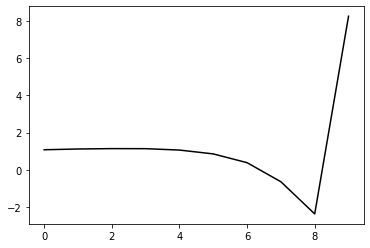

74000 0.27126957415433156
0.2837710671514602 -0.14683604384595875 -0.2261373085259961 -0.14605515686990367
[ 1.04245583  1.15537103  1.14593875  1.10146532  1.00232116  0.7818701
  0.30002239 -0.72966766 -2.45126524  8.27068858]


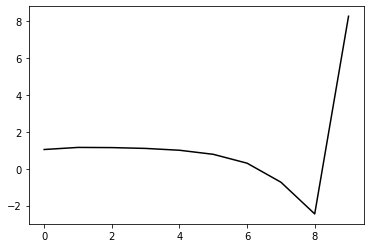

75000 0.21511789876731877
0.27788402025433073 -0.14800939405585944 -0.22659902180998193 -0.14446718223964086
[ 1.06146884  1.14985944  1.15355354  1.12950617  1.03808207  0.81402857
  0.32857149 -0.69864625 -2.40670163  8.24764771]


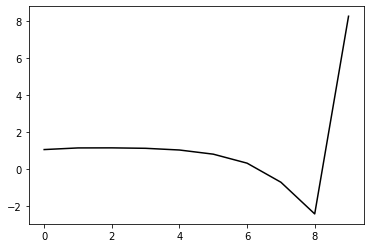

76000 0.19109048672085718
0.27728284899292743 -0.14756340854865432 -0.2272623510445813 -0.1425993504593811
[ 1.06279256  1.15397285  1.16509135  1.15173049  1.08192757  0.87941335
  0.41031273 -0.59855321 -2.27697965  8.2650655 ]


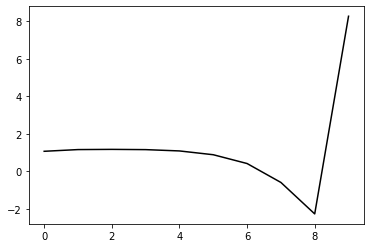

77000 0.20536817580930414
0.2715535995766738 -0.15085652019842183 -0.22736655075112389 -0.14433139104328602
[ 1.05039894  1.15028998  1.15298473  1.1242312   1.03756437  0.830231
  0.36699053 -0.62833077 -2.27450853  8.28336908]


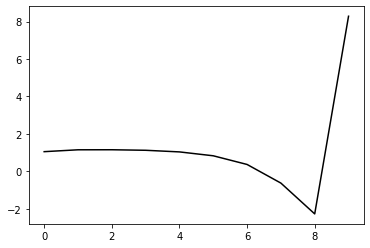

78000 0.2133260208868504
0.271742473228315 -0.15166326427669427 -0.2268955739915064 -0.14979460674455042
[ 1.0569594   1.14407045  1.1488259   1.12157723  1.03496031  0.8277199
  0.37183514 -0.60633224 -2.22032299  8.28833711]


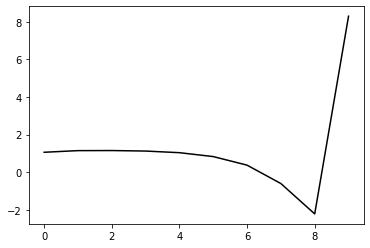

79000 0.22523060630704894
0.27277816833965846 -0.15137767910262137 -0.22506220301271998 -0.1511711657144418
[ 1.04825953  1.12179943  1.13807323  1.1175124   1.02463187  0.7980749
  0.32329712 -0.66006896 -2.25987144  8.29050922]


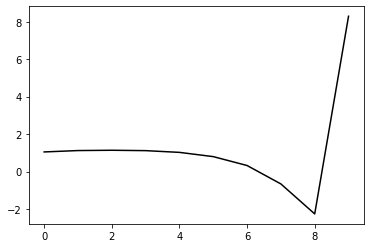

80000 0.17516773522162224
0.2741450911437285 -0.15253501058382346 -0.22633428736099623 -0.14777907194034784
[ 1.06285139  1.13656321  1.1490167   1.1254915   1.04373223  0.83568344
  0.37227543 -0.59869286 -2.16999172  8.30278663]


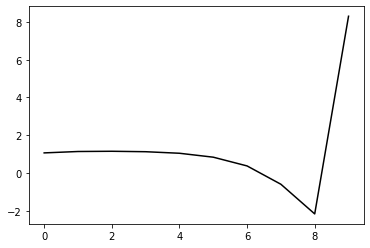

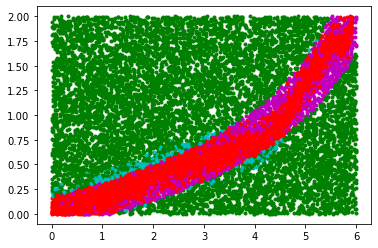

81000 0.18760138062611376
0.27549421781362676 -0.15000549511241815 -0.22565605774677733 -0.1443460132740038
[ 1.08209462  1.15517244  1.18920374  1.16557545  1.07022192  0.85159625
  0.38322483 -0.59089775 -2.15280726  8.29342863]


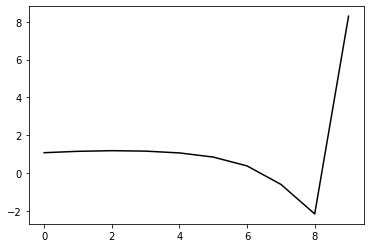

82000 0.1786009739705638
0.2732448699245615 -0.1509506341278314 -0.2251742726157152 -0.144799593169668
[ 1.07923034  1.16130261  1.1905959   1.16440556  1.06964525  0.84667828
  0.37198865 -0.60248775 -2.14746573  8.3124926 ]


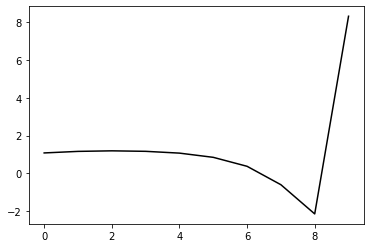

83000 0.15747490799975628
0.2685077392847629 -0.1508810974659377 -0.22415998590028188 -0.14459190141344774
[ 1.09749449  1.03070051  1.04201895  1.02615648  0.94564897  0.73520348
  0.26994986 -0.69533286 -2.2191741   8.29262393]


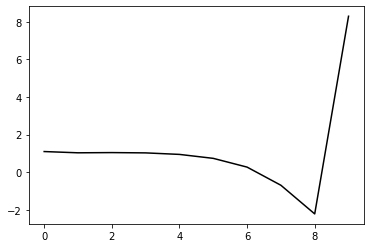

84000 0.1355072678516118
0.2705149480515305 -0.14923412784465337 -0.22401904908201692 -0.13897374626180306
[ 1.08870823  1.15916626  1.15212048  1.09933434  0.98993713  0.76437493
  0.29279339 -0.67605476 -2.18973334  8.29639913]


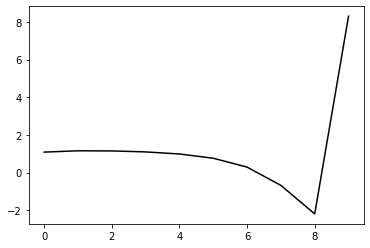

85000 0.1643733747868502
0.2717766714344949 -0.14998040210491978 -0.2244804254697811 -0.14095629333230306
[ 1.09016548  1.18233189  1.19668038  1.1718312   1.07999672  0.85768658
  0.38627652 -0.57514195 -2.0645036   8.27955629]


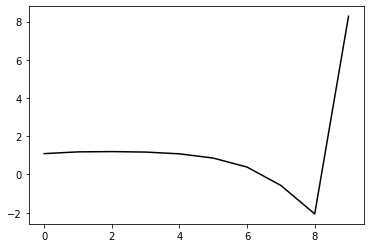

86000 0.176641330935545
0.2699646454908519 -0.1535167810001794 -0.22580736939526758 -0.13944863024144044
[ 1.06412245  1.1328856   1.12377757  1.09592054  1.0090972   0.7962022
  0.3322289  -0.61783949 -2.07479174  8.32151625]


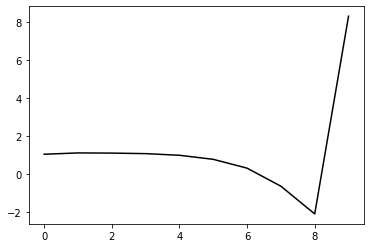

87000 0.23431165317703395
0.2708533744452346 -0.1489449737496572 -0.22399149036498692 -0.13723584900256605
[ 1.0786816   1.18612528  1.1892302   1.15664282  1.07373221  0.87216444
  0.42466573 -0.50863588 -1.94002492  8.33934618]


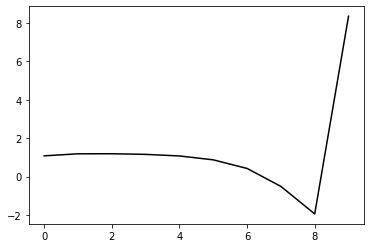

88000 0.20818072114350036
0.2646841904621427 -0.15244319896461725 -0.22562321945997335 -0.13912270170253252
[ 1.06563793  1.14514867  1.15805876  1.15255806  1.08819988  0.9047034
  0.48226934 -0.41998749 -1.80917052  8.36726297]


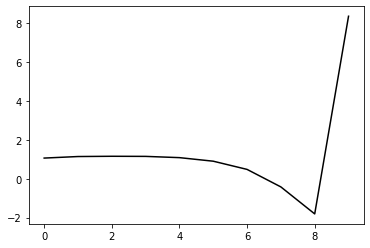

89000 0.1900914883291412
0.2646376204606458 -0.1498578407859998 -0.22305086789753867 -0.13732286298762877
[ 1.07750847  1.1226174   1.11396967  1.07924758  0.9832194   0.77586422
  0.34226722 -0.55887409 -1.93396427  8.33740335]


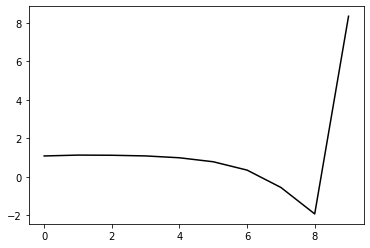

90000 0.24182168373706064
0.2684823937117452 -0.14876877813712017 -0.22246372738619685 -0.13644739773310716
[ 1.09579098  1.13034233  1.15846077  1.12485525  1.01115668  0.77597558
  0.31510571 -0.60176117 -1.97952721  8.37060721]


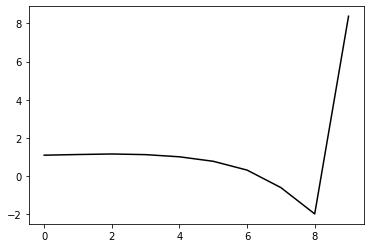

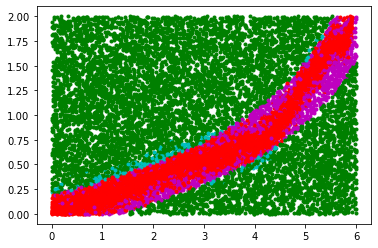

91000 0.17538585476024973
0.2704508897645171 -0.15093123395715505 -0.22442941510238573 -0.1358401502201156
[ 1.07076045  1.20558313  1.21807843  1.17965853  1.08498565  0.87619609
  0.43252267 -0.4671876  -1.81422874  8.38182053]


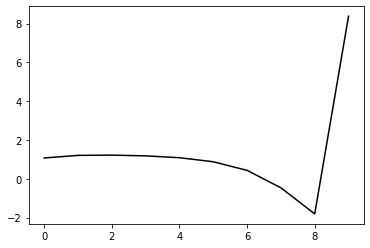

92000 0.1689709358287588
0.26938832326624446 -0.15006911394701247 -0.22249117198104507 -0.13664618818517432
[ 1.09389436  1.18159845  1.20925541  1.18663466  1.09350652  0.87341215
  0.42075265 -0.48141169 -1.81642794  8.33200069]


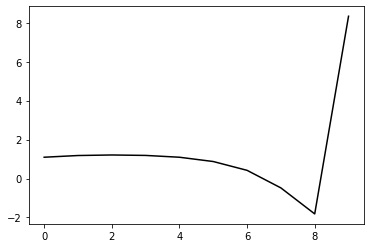

93000 0.20474171155267826
0.26870316702606317 -0.1513258307508952 -0.2220391098691665 -0.13775406607230078
[ 1.08439863  1.1770502   1.18967743  1.1562195   1.05522229  0.82755827
  0.36231366 -0.55098293 -1.88388637  8.33143066]


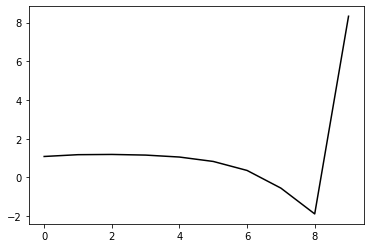

94000 0.14524101510861312
0.2681737786253927 -0.15125396984583694 -0.2211626963479935 -0.13610417176081138
[ 1.07040479  1.20522431  1.22230423  1.19303334  1.0894098   0.85053219
  0.36711628 -0.5674613  -1.91410554  8.32385598]


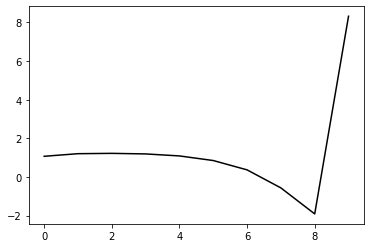

95000 0.2722093297309908
0.27120574252495916 -0.15243100981004062 -0.22190634907568177 -0.13684339980239907
[ 1.07521497  1.19218983  1.22581505  1.2103714   1.11678309  0.88159626
  0.39509942 -0.54566816 -1.886419    8.33679537]


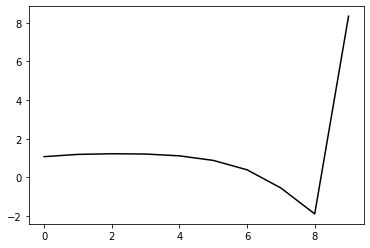

96000 0.18797582898161055
0.2731087519883496 -0.15240246407433827 -0.22223569488499098 -0.13372154519402007
[ 1.08128126  1.22092658  1.23630273  1.1963574   1.09849177  0.87567323
  0.40119528 -0.53324573 -1.85460761  8.33825004]


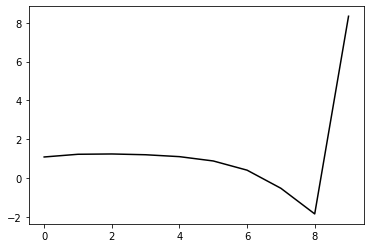

97000 0.18100265975606494
0.26995828558176516 -0.15621783604014203 -0.22311079103444942 -0.13764484076494599
[ 1.09085961  1.19202706  1.22808667  1.20260781  1.10394651  0.87666495
  0.40555984 -0.52452561 -1.83464344  8.3309377 ]


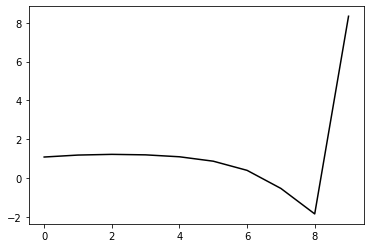

98000 0.203219121971483
0.27147211733286813 -0.15345156519712075 -0.22052260824903963 -0.13661426714273536
[ 1.0820323   1.20765497  1.2217611   1.19238659  1.09100474  0.85446446
  0.36919038 -0.57489225 -1.89364568  8.36230284]


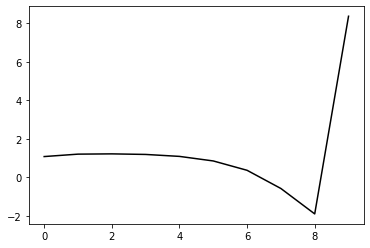

99000 0.20815906569281664
0.27172989568959527 -0.15326320272797633 -0.220138264959768 -0.13613037836576106
[ 1.07596459  1.19816078  1.20837159  1.18159059  1.08427901  0.85123814
  0.36653708 -0.57946099 -1.896719    8.38855788]


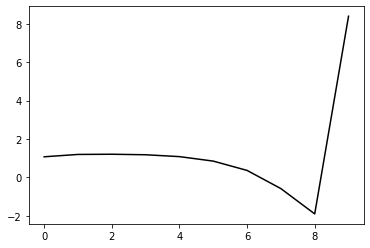

In [43]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.4655220819454024
0.2804720709587464 -0.162649405032957 -0.22845594901499783 -0.12916666224190682
[ 1.04751488  1.22754869  1.24280664  1.21734389  1.11917933  0.88547883
  0.40248727 -0.54012592 -1.84550431  8.33623253]


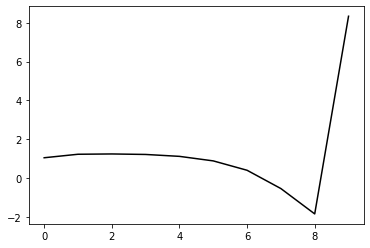

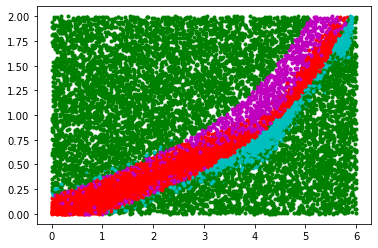

1000 0.19116834069046099
0.27367972261847673 -0.15893343160393034 -0.22059598212237388 -0.1429337466912944
[ 1.09867915  1.15955807  1.19715206  1.1815661   1.07902115  0.8321017
  0.33152761 -0.62848219 -1.94567286  8.31430227]


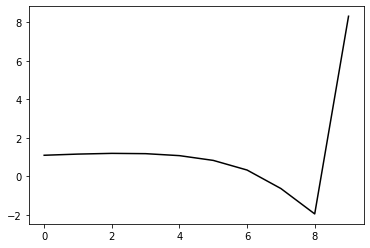

2000 0.2123612897266361
0.2748616343067463 -0.16256491716927143 -0.22341012969667717 -0.1420279147779964
[ 1.07481875  1.13966457  1.16457496  1.16023277  1.08206203  0.85211139
  0.35396154 -0.61076964 -1.92976074  8.33019101]


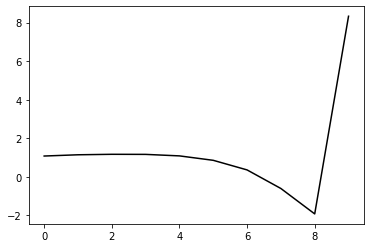

3000 0.25206475377912496
0.2714182678496266 -0.1621340617272166 -0.2238693791871641 -0.13871003510754976
[ 1.05920799  1.05325501  1.05326373  1.03783011  0.9617477   0.75225599
  0.27677279 -0.68007459 -1.99725911  8.33076084]


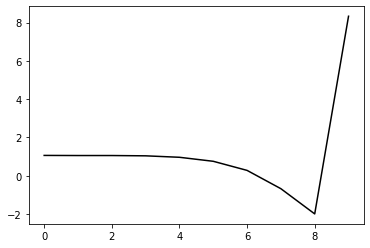

4000 0.14335196850548862
0.2698812791371505 -0.15515068960255296 -0.21903723752804288 -0.14281157529901775
[ 1.03905147  1.11792295  1.10660515  1.07876672  1.00121385  0.80114593
  0.34605222 -0.59594558 -1.90886208  8.34570849]


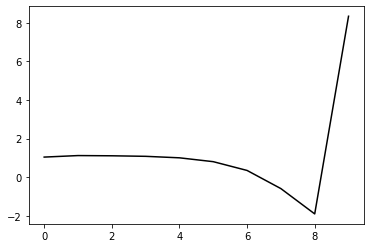

5000 0.196695630528287
0.26681526345603046 -0.15852688438288545 -0.2199317165168529 -0.1455421454328697
[ 1.04602848  1.11278694  1.10604817  1.07459363  0.98287078  0.77003991
  0.31849597 -0.60814377 -1.9075895   8.35230808]


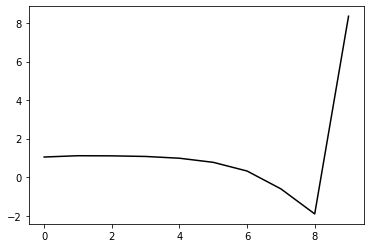

6000 0.16826700410788273
0.2692051758693984 -0.15937902093727557 -0.21954210727839615 -0.1469742620005244
[ 1.05336218  1.10473824  1.14322003  1.11663864  1.00483435  0.76924863
  0.29951666 -0.63567391 -1.94643037  8.33246963]


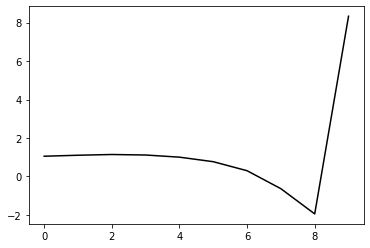

7000 0.16198325562657354
0.2688958241525538 -0.1589519818831618 -0.21970974785852793 -0.14327207029106714
[ 1.04384227  1.06577115  1.04639514  1.0136878   0.91987067  0.70123896
  0.23878143 -0.68579655 -1.98565046  8.33255685]


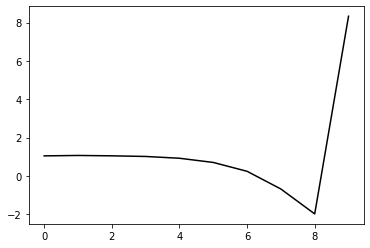

8000 0.27054828071676307
0.2691713938391539 -0.15699377114936594 -0.21758679652186516 -0.14686619746199991
[ 1.03983133  1.10777559  1.0927988   1.04797123  0.95192473  0.74033872
  0.28862408 -0.62530858 -1.9138494   8.34892317]


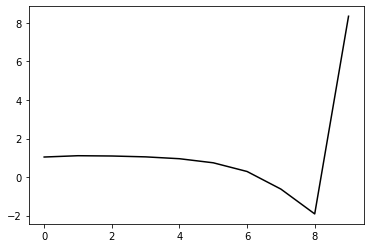

9000 0.15343943625296372
0.2659785623207971 -0.15915251693053173 -0.2187574027819589 -0.1462506297070639
[ 1.04905227  1.11247041  1.13754612  1.1102819   1.00434657  0.77589061
  0.3125493  -0.60902386 -1.90582927  8.34524684]


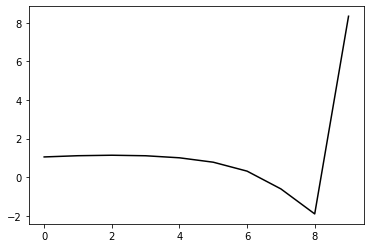

10000 0.20574829645290538
0.264493034824824 -0.15942649347215698 -0.21768743133564525 -0.1452652394427755
[ 1.0239936   1.09287475  1.06306752  1.02124986  0.92612701  0.70224202
  0.23443223 -0.68733363 -1.97805317  8.3330581 ]


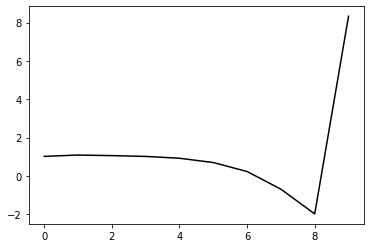

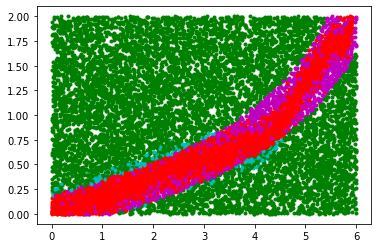

11000 0.20375668788597537
0.2643855395256815 -0.15930635652162528 -0.2179464136916454 -0.1457957005448873
[ 1.04675671  1.10707856  1.10245901  1.06882943  0.98119094  0.77270966
  0.32162038 -0.5856182  -1.85848989  8.34364244]


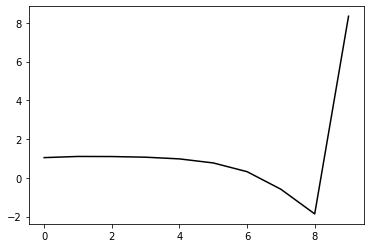

12000 0.17221001605044803
0.2646930289424933 -0.1603062488388824 -0.21882915151716495 -0.14558140684585763
[ 1.04783984  1.06672885  1.07573201  1.06309694  0.99445236  0.79491432
  0.34916522 -0.55342071 -1.8198235   8.33753935]


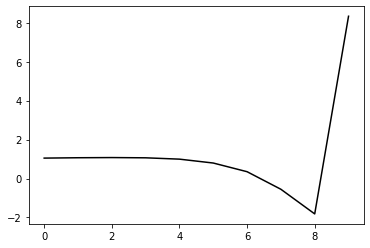

13000 0.22505779231699363
0.26744133431953654 -0.1595114331622593 -0.21847832197973485 -0.14355018448429815
[ 1.05527996  1.10633919  1.10764648  1.07318336  0.98734488  0.78689669
  0.34812504 -0.54818573 -1.8066889   8.33664491]


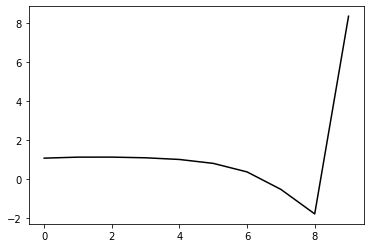

14000 0.18999290740197494
0.2645145858735731 -0.16137383931523416 -0.21929714756364221 -0.14262964799022618
[ 1.04814894  1.07297609  1.04776817  1.01161201  0.92343343  0.72195608
  0.28999244 -0.59369958 -1.83761808  8.34887118]


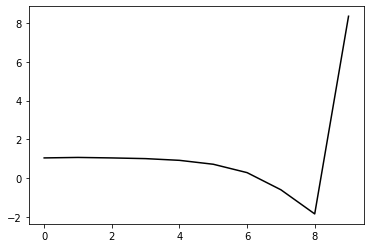

15000 0.25306944884107613
0.2694547841319163 -0.16179491481486552 -0.21934646244765577 -0.1444104643755626
[ 1.05809549  1.07693588  1.07565368  1.04293189  0.96002927  0.76513706
  0.34425522 -0.52038101 -1.74021097  8.34772195]


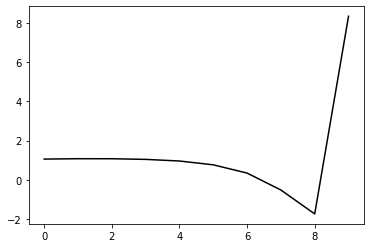

16000 0.2141454970468606
0.26582859326012115 -0.16278025034023622 -0.21991410124598876 -0.14308152851243106
[ 1.05240135  1.09118736  1.08166485  1.04620134  0.95673858  0.76134199
  0.34599831 -0.50828041 -1.71730562  8.39056314]


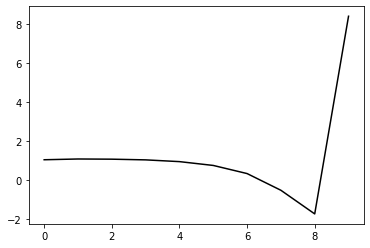

17000 0.156105827651243
0.2666585358288388 -0.16143017853250252 -0.21900810272026133 -0.1428927123038419
[ 1.05956042  1.10691686  1.1196599   1.08036505  0.97439225  0.75638718
  0.32341258 -0.53842281 -1.75059021  8.34321323]


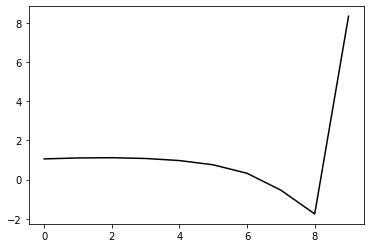

18000 0.1882775154297818
0.267781365612207 -0.1570285651577135 -0.21638294681356124 -0.14056405698729385
[ 1.0327137   1.09592558  1.0740049   1.03046853  0.91950538  0.67948641
  0.21269752 -0.67429674 -1.89982756  8.33479742]


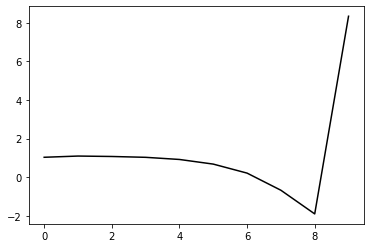

19000 0.2389751257761878
0.2702519007037707 -0.1571852162497865 -0.2161352618425238 -0.14187595938136863
[ 1.02419407  1.09163801  1.10003234  1.04243297  0.91098002  0.6539782
  0.16593015 -0.7419614  -1.97409956  8.32742545]


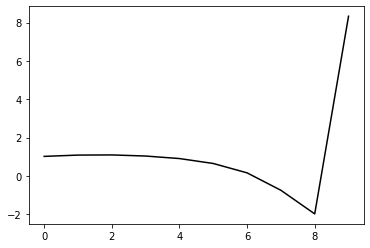

20000 0.23676847652695696
0.26843333861357255 -0.16062708158877276 -0.2182387753378916 -0.14116687223744406
[ 1.07393669  1.14768791  1.17496241  1.15352982  1.05644719  0.81622354
  0.32930576 -0.58423191 -1.81292054  8.34922782]


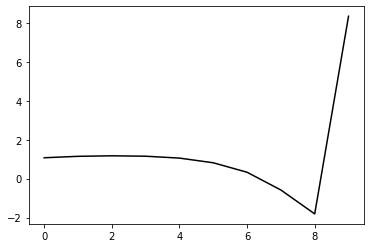

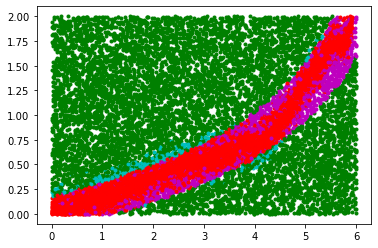

21000 0.18316066853469645
0.26746829770034775 -0.1608648002919855 -0.21767762668482554 -0.14074446808000704
[ 1.04345107  1.08321834  1.08337324  1.07065736  0.98278835  0.75294771
  0.26723945 -0.65716831 -1.8908982   8.31414489]


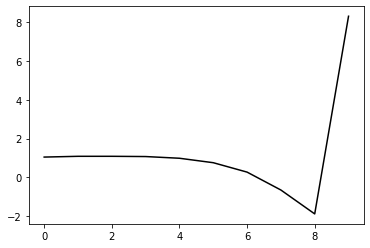

22000 0.1387673606013966
0.27046595660170053 -0.159312940277708 -0.21767913598366428 -0.13888029987002923
[ 1.07323593  1.12762657  1.14354591  1.11063535  1.01651471  0.79860058
  0.32882897 -0.59479341 -1.83242781  8.33827794]


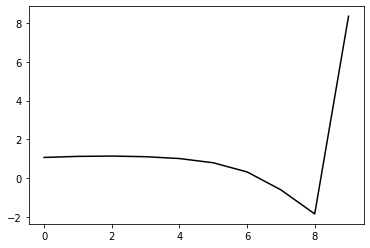

23000 0.13895739242723237
0.2662623084744707 -0.16366288249041547 -0.22043569001041455 -0.14034474542906514
[ 1.06682938  1.11846716  1.14096002  1.12851744  1.05374883  0.85745723
  0.41580024 -0.48401704 -1.70302518  8.36630947]


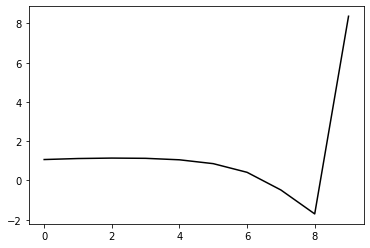

24000 0.17069082942483899
0.26884627674035383 -0.15769387132357118 -0.21556519358705134 -0.1392544429233238
[ 1.04026805  1.17713756  1.1892154   1.14788065  1.03790263  0.80878188
  0.34431156 -0.57424837 -1.81769674  8.35026625]


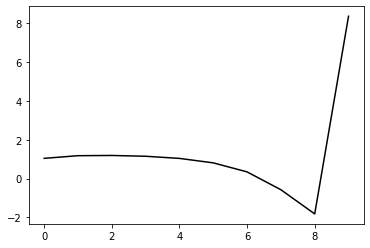

25000 0.29159914860103303
0.27415124068266866 -0.1587007789493179 -0.21695249231772248 -0.13685402727558837
[ 1.06181218  1.20270792  1.22790178  1.1951674   1.08714271  0.84608585
  0.36733553 -0.55650271 -1.80098089  8.33734376]


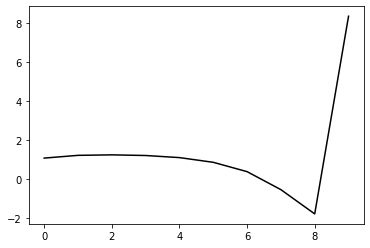

26000 0.1475900388987739
0.27064368296272345 -0.1593392698920735 -0.21709330680219305 -0.13741880721456942
[ 1.06301778  1.18063837  1.19067544  1.15489218  1.05640129  0.83207792
  0.36441661 -0.54883265 -1.77942936  8.36695363]


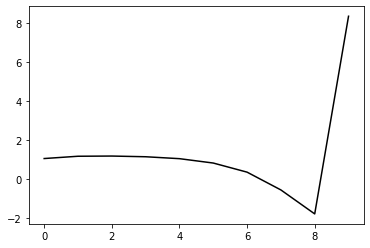

27000 0.1832688209035535
0.2641751269514763 -0.16707589659103275 -0.22019582527691334 -0.14102077269555088
[ 1.05710248  1.16234248  1.17237708  1.12871273  1.02517091  0.8036761
  0.34825501 -0.5471484  -1.75151352  8.3593196 ]


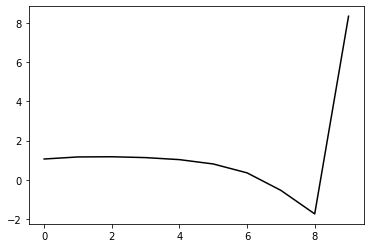

28000 0.21946530187122562
0.2637319048032339 -0.1623532521503535 -0.21632263813684868 -0.14162704248757754
[ 1.07214663  1.02393188  1.0166607   0.98620668  0.88523882  0.65124241
  0.17973647 -0.72958156 -1.94820766  8.33350832]


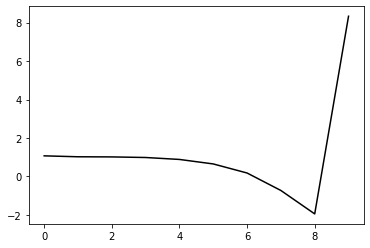

29000 0.18918047466029045
0.270163384958961 -0.16328415615601696 -0.21622329314904537 -0.1454030201138312
[ 1.05436125  1.1237177   1.15944895  1.13825962  1.0239538   0.76686525
  0.26827165 -0.66273397 -1.89147383  8.3421234 ]


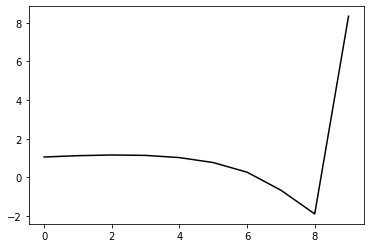

30000 0.1650026874832835
0.2718212633694958 -0.16152561430672305 -0.21565645774993814 -0.1424305191802139
[ 1.0609468   1.08780252  1.08167996  1.04659828  0.94598532  0.7137053
  0.22669559 -0.70627519 -1.93538589  8.34786851]


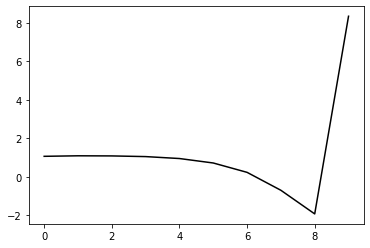

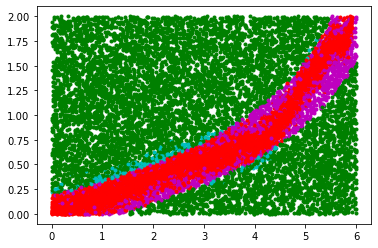

31000 0.17270979709096526
0.2747962421977294 -0.15990060769019648 -0.21571047621520487 -0.1414042677894383
[ 1.03120593  1.09054825  1.06538877  1.01513747  0.91207213  0.68886853
  0.22094834 -0.69705802 -1.91242931  8.34943563]


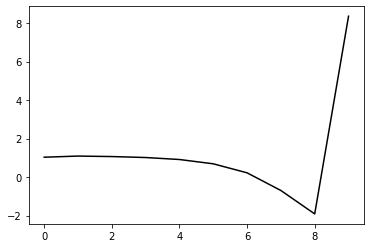

32000 0.17597374373265132
0.2752040778084174 -0.16049922126132854 -0.21501979501401167 -0.1459867572965387
[ 1.02503376  1.16591691  1.16449116  1.10928231  0.98640664  0.73882545
  0.25784554 -0.66528857 -1.88286587  8.35965864]


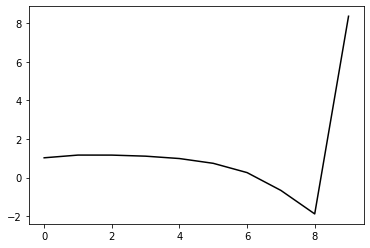

33000 0.2558544420892835
0.26942184330261154 -0.16575561442161998 -0.21702784547405493 -0.14835747436192886
[ 1.04624879  1.11630403  1.11959939  1.0859528   0.9855797   0.74977723
  0.27092186 -0.647581   -1.85980303  8.303617  ]


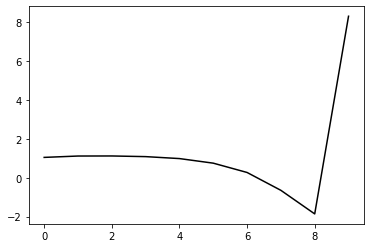

34000 0.18862495658413714
0.2714558638396381 -0.16056353698029158 -0.2143320515876782 -0.14713269621691452
[ 1.03641337  1.02409543  1.04322023  1.02599026  0.93430051  0.70520439
  0.224819   -0.70295323 -1.92883974  8.32152686]


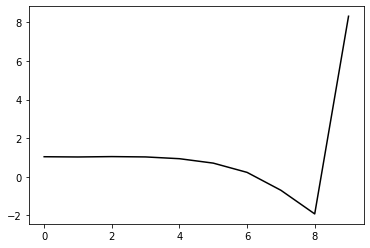

35000 0.27196709154371174
0.2622964824334394 -0.16373706221074488 -0.21601415916795025 -0.1485766267756124
[ 1.0330246   1.08707459  1.08040723  1.03074476  0.93702971  0.73734885
  0.29419533 -0.60836345 -1.81950806  8.33890982]


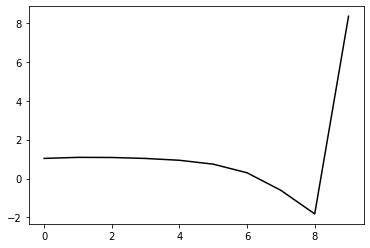

36000 0.25499253771921604
0.26783313457675695 -0.15879193760155794 -0.21349222772532478 -0.14570942526923078
[ 1.02078111  1.06565154  1.05804405  1.00347     0.8933552   0.67211692
  0.22194791 -0.67858307 -1.89095186  8.32655608]


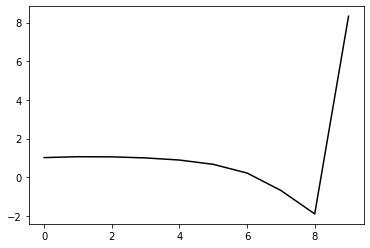

37000 0.20360243036827275
0.26638425250613895 -0.16325883723379692 -0.2151227774062526 -0.1482746550725472
[ 1.02666252  1.09107287  1.09998636  1.05420447  0.93919493  0.71070984
  0.25885127 -0.63234921 -1.83346553  8.33180676]


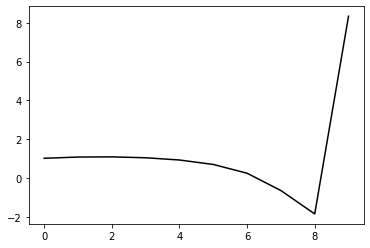

38000 0.14081622535191374
0.2664264100510828 -0.1618801273913218 -0.21476105577350624 -0.14735050163439348
[ 1.02998976  1.10337939  1.1069412   1.06036617  0.94849894  0.71835513
  0.25881501 -0.63514405 -1.83950922  8.33738935]


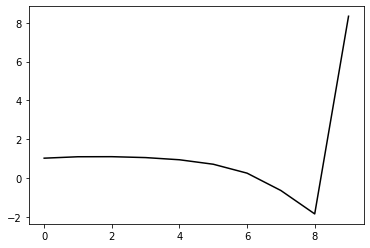

39000 0.1304944074163634
0.26798092708627164 -0.16032156202397338 -0.21442302481321251 -0.1460826602210681
[ 1.02134804  1.07739458  1.06498105  1.01949706  0.91490666  0.6959203
  0.24669459 -0.63597084 -1.8277185   8.34788068]


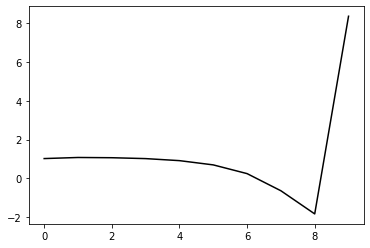

40000 0.26455979465089857
0.2639633884759196 -0.1615453541091028 -0.21300989969579054 -0.15129795833799492
[ 1.01938281  1.0463881   1.02839744  0.98129758  0.88477553  0.67855777
  0.2495348  -0.60839946 -1.77184473  8.39475467]


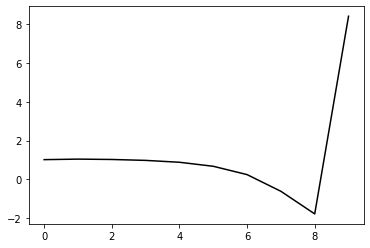

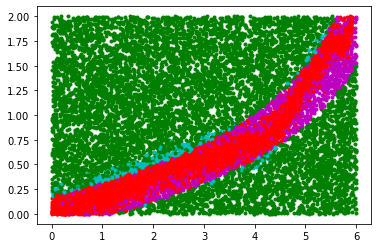

41000 0.23188028810855454
0.26510142048628915 -0.1606414655428539 -0.21315489570852247 -0.14883856215513092
[ 1.01533633  1.02580271  1.02503651  0.98156255  0.87287988  0.65009922
  0.20951528 -0.65381494 -1.82086785  8.3168792 ]


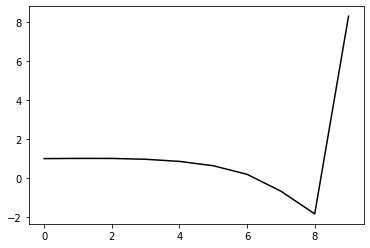

42000 0.13504477446227053
0.25892469770102533 -0.16446841632976228 -0.21507945986943336 -0.15141280394344664
[ 1.01742066  1.05271821  1.04484305  1.00959103  0.91589768  0.70083663
  0.26195102 -0.59604726 -1.75473308  8.33382864]


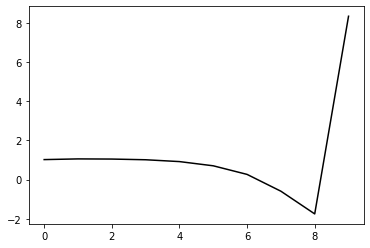

43000 0.19235684069783135
0.2604223944792595 -0.16456980372823435 -0.21604778299028676 -0.14969061046511406
[ 1.01584337  1.05048092  1.03547955  0.99255462  0.90464211  0.70451116
  0.27915244 -0.56674779 -1.71215255  8.36687541]


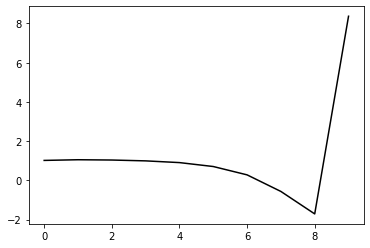

44000 0.2290944929382677
0.25980540624818094 -0.1653643543138386 -0.21689099730597922 -0.14987307191140525
[ 1.01210443  1.04228467  1.02930317  0.9937287   0.90655073  0.70848207
  0.29303853 -0.54001078 -1.66897852  8.36331194]


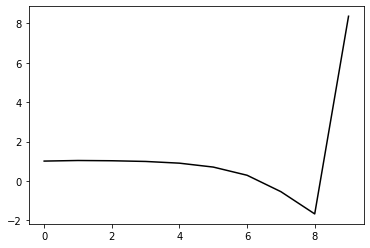

45000 0.2199232898844104
0.258678021742292 -0.15911427429070593 -0.2129802228188351 -0.14624478610851793
[ 1.00582642  1.00593838  0.95276765  0.89329386  0.79159669  0.58716235
  0.17102188 -0.65737779 -1.77845083  8.35535295]


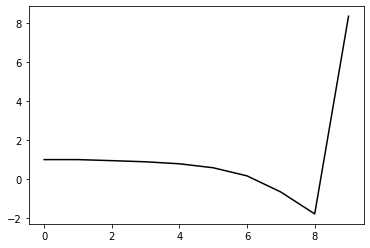

46000 0.22601570698651907
0.25534690250838055 -0.16201681900522386 -0.2148031288868225 -0.14670792148548287
[ 1.02756157  1.05758948  1.02660279  0.97349896  0.87920129  0.68600947
  0.28551322 -0.52292864 -1.6213264   8.38318336]


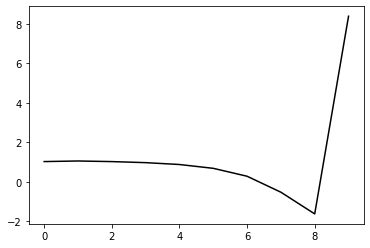

47000 0.1949713434285032
0.26283496409283574 -0.16518466332712 -0.21762350261821053 -0.14676667767335447
[ 1.01439655  1.07537329  1.07342199  1.02715231  0.92207512  0.71110093
  0.2978363  -0.51407702 -1.61078507  8.39154089]


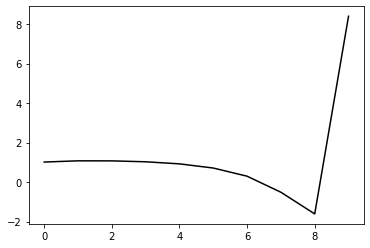

48000 0.20426367831644865
0.262411050972489 -0.15758726095902556 -0.21305880567452315 -0.14469375781427052
[ 1.00236483  1.01357161  0.97600195  0.91624357  0.81221348  0.59817978
  0.17213622 -0.65038993 -1.75343706  8.36768352]


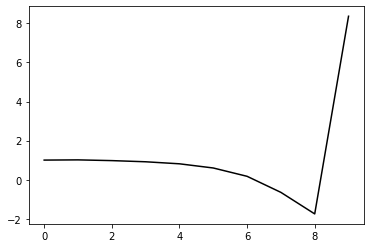

49000 0.19177529435756005
0.25920756148742286 -0.16341742979448154 -0.21513710873710448 -0.1474743449644327
[ 1.03171654  1.08075752  1.08503404  1.03621619  0.91782779  0.685574
  0.24536913 -0.58501848 -1.68216178  8.36537482]


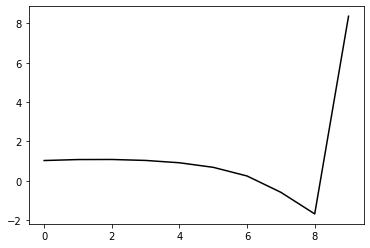

50000 0.17025829292382266
0.26311381246900667 -0.16002487868780987 -0.21423188441214655 -0.1452963743362052
[ 0.99773238  1.09111454  1.07746594  1.01335182  0.89064554  0.65645171
  0.20510059 -0.63761807 -1.73685078  8.36597262]


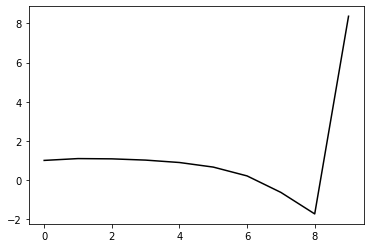

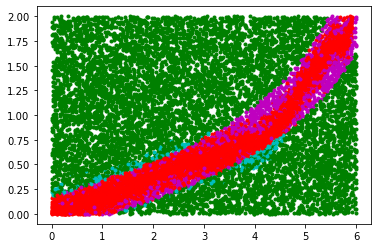

51000 0.23157700227861244
0.2594207374885787 -0.159326507899699 -0.21463304016270435 -0.14638586313592522
[ 1.02519157  1.05761939  1.03554897  0.99565209  0.90522856  0.69655352
  0.26603735 -0.56242973 -1.64428041  8.40510878]


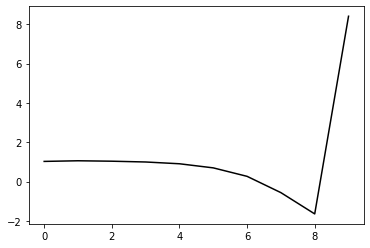

52000 0.19168197216659585
0.25765154669792495 -0.1636979109961757 -0.21782225236031783 -0.14570064725381646
[ 1.03018675  1.07252517  1.06568437  1.01823187  0.91934765  0.72053541
  0.30811757 -0.5075004  -1.57673908  8.37903296]


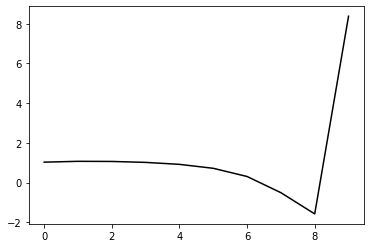

53000 0.12743511667101573
0.25734026628300205 -0.16111548011506668 -0.2163050856733897 -0.1441710346614443
[ 1.04505432  1.07476925  1.05796591  1.00672895  0.89805316  0.68828103
  0.27569303 -0.53272559 -1.59121351  8.38790861]


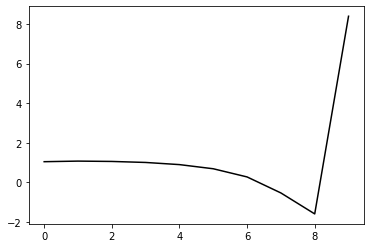

54000 0.1482385284459056
0.2670916827675826 -0.1586234223050001 -0.21409353175252263 -0.1468255637382353
[ 1.02518116  1.13414034  1.11954453  1.06242673  0.93963905  0.69535019
  0.24700687 -0.58243842 -1.64920964  8.35492432]


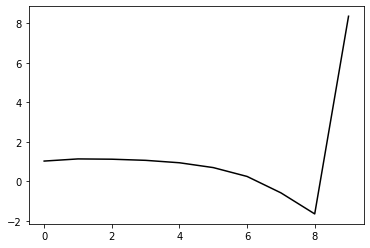

55000 0.19858287392072546
0.26287349164407603 -0.16282730946152318 -0.21652986521810003 -0.1452347766810611
[ 1.04653921  1.09204162  1.0772506   1.02850496  0.913289    0.67814509
  0.22764184 -0.60640472 -1.67168642  8.38020741]


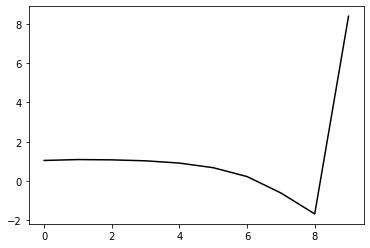

56000 0.17195496526791249
0.27202130625767246 -0.1587863561579741 -0.21455908762568435 -0.14500373875630165
[ 1.00996331  1.13846585  1.13209808  1.07697948  0.94803371  0.69008081
  0.20973281 -0.65465476 -1.73702996  8.36141831]


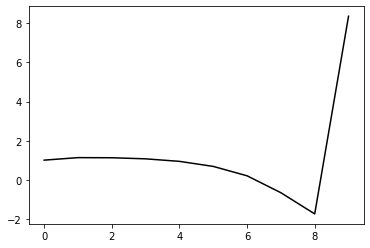

57000 0.2491064690607319
0.2687930145834585 -0.15900829291709262 -0.2159123026103002 -0.14433422564079235
[ 1.0275619   1.13914039  1.15049502  1.11106132  0.99966929  0.75662756
  0.2796232  -0.59368639 -1.68241918  8.37236237]


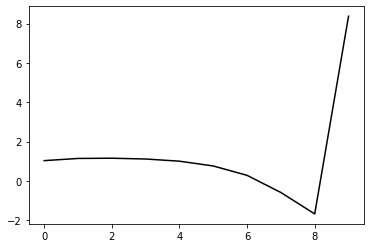

58000 0.2827609772260725
0.2642736858363779 -0.16241978666236118 -0.21819780609901107 -0.14360917213225122
[ 1.05588537  1.12139689  1.1309147   1.10018443  1.00027085  0.76676562
  0.29478345 -0.58199757 -1.66914173  8.40712628]


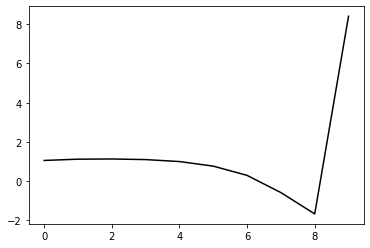

59000 0.16260757531696074
0.26392862653974525 -0.16199065768259832 -0.21685605180142697 -0.14559390665801758
[ 1.05232487  1.14172714  1.1587765   1.12732992  1.01820711  0.76969787
  0.27664489 -0.62975953 -1.74675531  8.36488245]


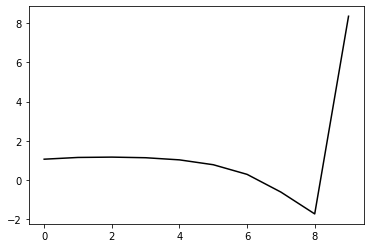

60000 0.1939069451521221
0.26409512051272915 -0.16231069174045873 -0.21720568919938532 -0.14335632460636077
[ 1.05800651  1.14206989  1.17079156  1.1381944   1.02643467  0.77967275
  0.28433815 -0.6342369  -1.76598788  8.3555578 ]


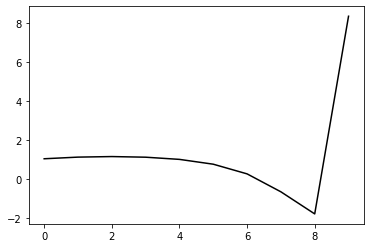

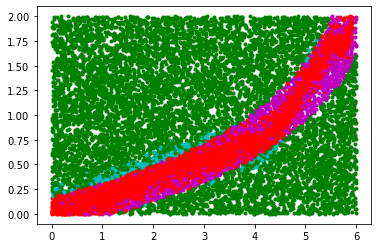

61000 0.20246747946843574
0.26370273207457096 -0.16059777606472647 -0.21698472224467338 -0.13811339781826062
[ 1.04063113  1.13812721  1.13585937  1.10062559  1.00378871  0.77002015
  0.27968541 -0.64789684 -1.79946947  8.35558626]


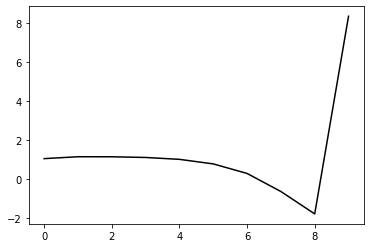

62000 0.25842694544215983
0.264622868828429 -0.16525988092751684 -0.21940748689153375 -0.14229443998254526
[ 1.03908891  1.1051299   1.12123108  1.11305052  1.03707513  0.82176397
  0.35425335 -0.55520698 -1.69305048  8.38852132]


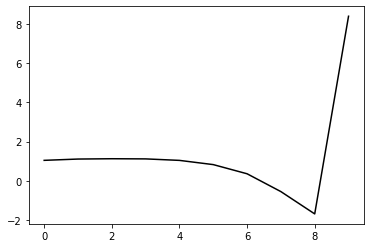

63000 0.1703391123887932
0.26274419508151564 -0.1652625761111578 -0.21921539778979487 -0.14313632736128387
[ 1.048127    1.10521944  1.12127176  1.10530134  1.01939421  0.8015469
  0.33743649 -0.57094449 -1.71594391  8.35552233]


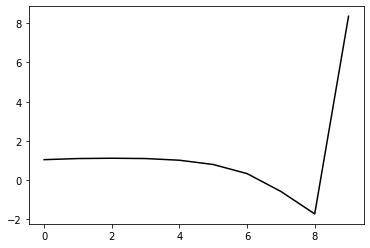

64000 0.15312837901650186
0.26288625223786394 -0.16684384880978467 -0.22083214466905532 -0.1439312449588685
[ 1.04171928  1.12116253  1.13862768  1.10808426  1.0082672   0.78218198
  0.31602586 -0.59234526 -1.74516339  8.36477312]


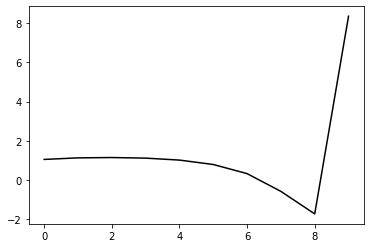

65000 0.19420402563410658
0.2651786249652953 -0.16084506581530736 -0.2185207188018851 -0.1347728643722571
[ 1.05061549  1.11258804  1.07996395  1.02651778  0.91478408  0.68330256
  0.21235421 -0.70321253 -1.87751924  8.34381013]


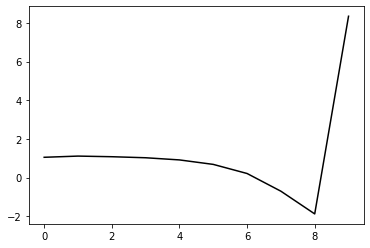

66000 0.27447077349564714
0.2645727060357534 -0.1641334328443749 -0.2203212083323114 -0.13918878106298457
[ 1.06526031  1.09325193  1.08335131  1.05940748  0.97158915  0.75462799
  0.29979201 -0.59530413 -1.7532518   8.34958637]


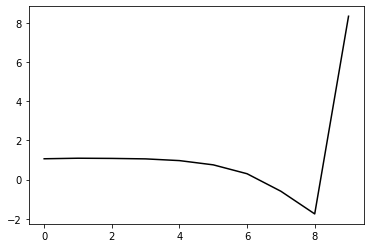

67000 0.20059151443040796
0.2729635559304128 -0.1598158052219174 -0.21722410291410407 -0.14318223943938577
[ 1.04096256  1.14476499  1.16781385  1.13034405  1.00806314  0.75885962
  0.27957687 -0.63233791 -1.8062379   8.39495843]


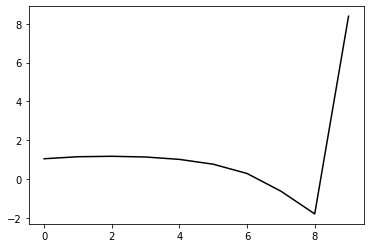

68000 0.22120775781025961
0.27158163798131946 -0.16425563446608568 -0.22027032873038127 -0.14277712958700153
[ 1.05531258  1.14497361  1.16988789  1.13795615  1.03540182  0.80553241
  0.33565367 -0.56841038 -1.73789114  8.346188  ]


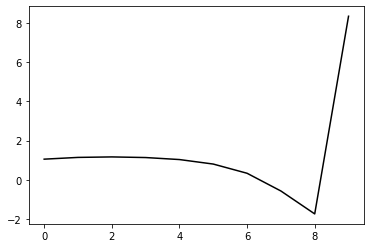

69000 0.19648132719271544
0.27583859606599237 -0.15786808569116098 -0.2161727447653421 -0.14166668130565674
[ 1.02997428  1.13535122  1.1027768   1.06453337  0.98078117  0.76751954
  0.30828943 -0.58888326 -1.75451513  8.3613968 ]


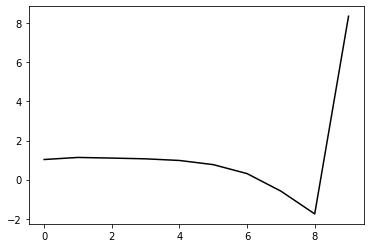

70000 0.1423743540969768
0.2755557738393251 -0.16069734231995417 -0.21704060694654867 -0.14424763678078475
[ 1.03975535  1.10858142  1.09178969  1.03991788  0.93229845  0.71301541
  0.26493335 -0.61826747 -1.76991046  8.35182303]


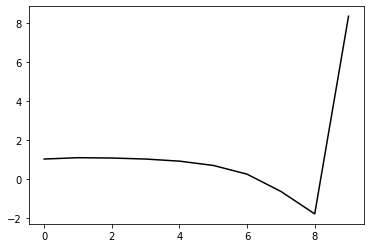

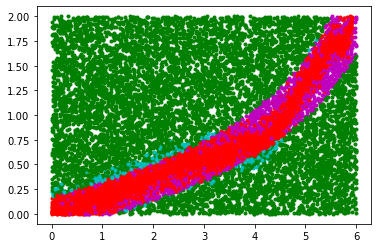

71000 0.15583087898680575
0.27615991935562884 -0.16179351837920533 -0.21715070457573538 -0.14514482442628973
[ 1.05915291  1.1185597   1.12224775  1.08269889  0.97030347  0.72939457
  0.2606925  -0.63433161 -1.79838647  8.34702548]


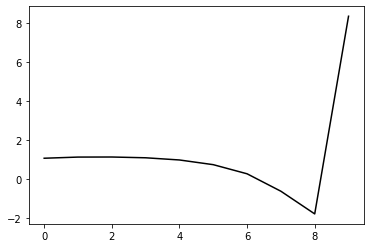

72000 0.1793616121316544
0.2785768496447231 -0.16278489737317758 -0.21841852315456753 -0.14155543587768063
[ 1.05206631  1.07707272  1.07658906  1.04014368  0.91946913  0.66428462
  0.17273861 -0.7421696  -1.92207392  8.31883839]


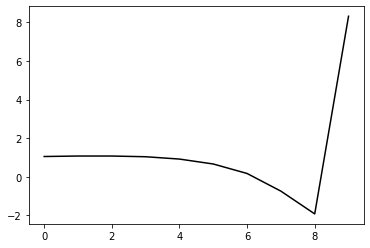

73000 0.13646216835669858
0.28000777246150144 -0.16166544333135474 -0.21806312775104691 -0.14297569020799664
[ 1.06792036  1.08439001  1.10763973  1.07828697  0.96978876  0.72159937
  0.22529987 -0.70082497 -1.8908987   8.34659091]


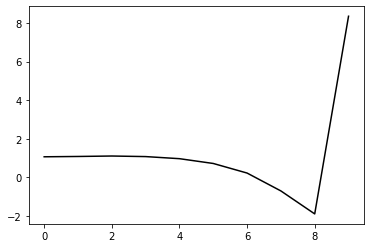

74000 0.2644527876723596
0.27976846008756445 -0.15834871353375315 -0.21591229803495998 -0.14143837532109113
[ 1.05643518  1.17489745  1.18095107  1.14062463  1.03324841  0.79293514
  0.30356225 -0.6225286  -1.81328028  8.34370907]


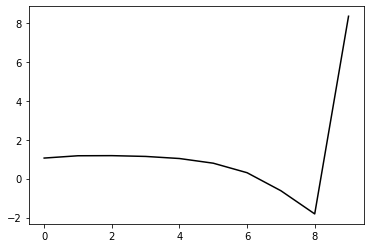

75000 0.20368865192372593
0.2801594122835924 -0.16034320348525005 -0.21595341684807315 -0.14379245481218172
[ 1.04329824  1.17825187  1.18050527  1.1273606   1.01090166  0.7646299
  0.27154017 -0.65895863 -1.8482203   8.32905471]


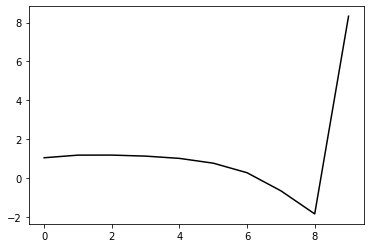

76000 0.20771858676012125
0.27441086823816907 -0.1656486855049863 -0.21748127570673606 -0.1478582763034376
[ 1.05291564  1.11854206  1.12187173  1.08801723  0.98219504  0.7410977
  0.25716045 -0.66240309 -1.83770985  8.36303405]


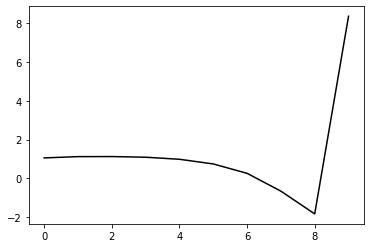

77000 0.19808489043360872
0.27187327512475407 -0.16524114962442907 -0.21654806790448772 -0.14557827990910827
[ 1.03042549  1.07872224  1.05955014  1.01870816  0.91116648  0.67316809
  0.18733706 -0.73903554 -1.92565755  8.34643134]


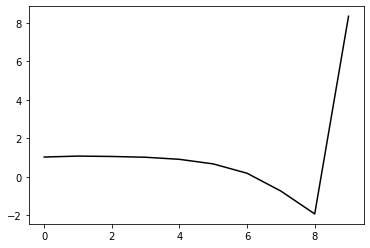

78000 0.2129777425493734
0.2703338169298855 -0.16359187000748224 -0.21674859943244046 -0.14750369893280893
[ 1.02121461  1.07057144  1.08076919  1.05593836  0.96144817  0.73922244
  0.26975148 -0.64800054 -1.83699427  8.33062736]


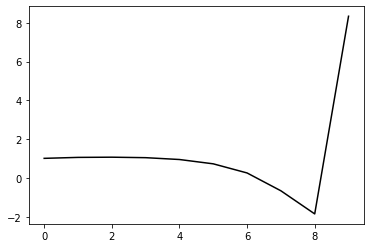

79000 0.2241926434984976
0.271712660128968 -0.1613678553995493 -0.21545104660846573 -0.14704066518411985
[ 1.04203682  1.09839626  1.08198837  1.03626138  0.93818646  0.72043614
  0.26160824 -0.64649768 -1.83261617  8.33659366]


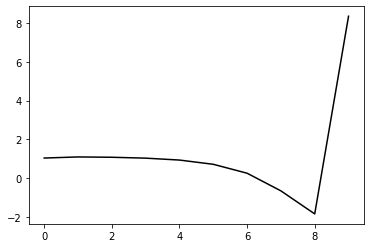

80000 0.19496029932312264
0.2735664410258777 -0.16512857526666883 -0.21681521876285645 -0.14984971044724918
[ 1.05276335  1.09665123  1.10224564  1.06254014  0.95263813  0.71985738
  0.25451032 -0.6524253  -1.83782509  8.40287345]


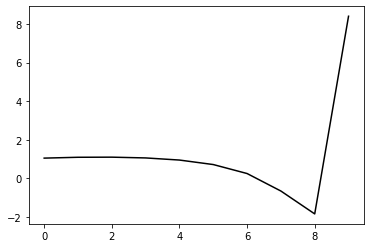

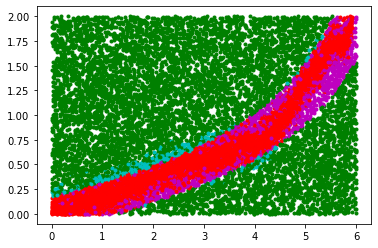

81000 0.1744860272438093
0.2771438077331628 -0.16342669619936345 -0.21678549231305252 -0.14643218840761812
[ 1.03426875  1.09574217  1.10234213  1.06740375  0.96329619  0.72919314
  0.25495722 -0.66048393 -1.8613863   8.33771329]


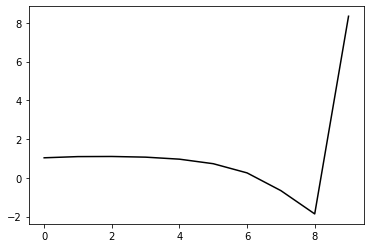

82000 0.17907630251549606
0.2750734259216446 -0.15962573195686486 -0.21544771617665562 -0.1449698083136066
[ 1.04016061  1.11873264  1.12489555  1.09500841  0.99515188  0.76439159
  0.28871278 -0.63578319 -1.85856157  8.3499389 ]


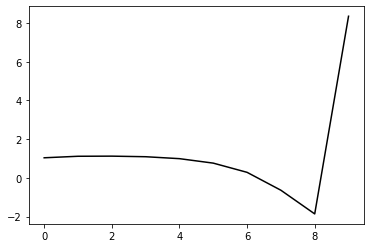

83000 0.14744130315464915
0.27393591328652167 -0.16092472240623318 -0.21574644289760053 -0.14407823742405837
[ 1.02856835  1.08741295  1.08922312  1.07427837  0.99042533  0.77093262
  0.3026402  -0.61652226 -1.83572515  8.40151807]


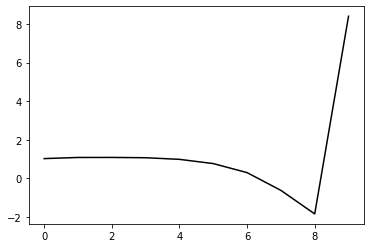

84000 0.12999549783630557
0.27214589292926755 -0.16282169314807882 -0.21665437340827534 -0.14426740918848246
[ 1.05356149  1.09578767  1.10881003  1.08641126  0.99631789  0.78140349
  0.32273829 -0.58914255 -1.80523564  8.34690256]


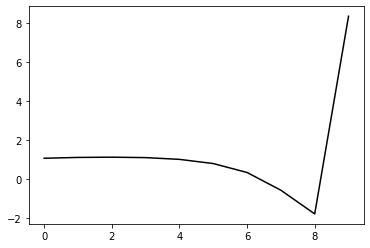

85000 0.1684620561032614
0.27475042600452815 -0.16415581388749287 -0.21592290311014845 -0.14873006538250239
[ 1.04320896  1.12379473  1.14249443  1.09565703  0.96749413  0.71479456
  0.22792425 -0.70303467 -1.93298093  8.31838302]


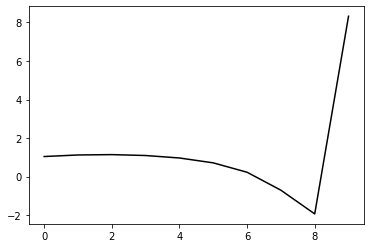

86000 0.18744224795969672
0.2757705098914916 -0.16331331572202826 -0.21708259417116982 -0.14541327850636712
[ 1.06008842  1.10772198  1.11241618  1.08855688  0.99827756  0.76685917
  0.282778   -0.65097556 -1.89155916  8.34144066]


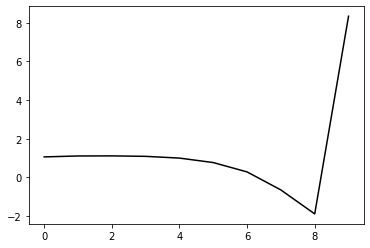

87000 0.2254298412549346
0.27315879161262996 -0.16369537751561894 -0.21781337498909864 -0.14629349483450424
[ 1.05339525  1.08312679  1.07174995  1.04910709  0.98225746  0.79192544
  0.34589733 -0.56140711 -1.78096692  8.35781468]


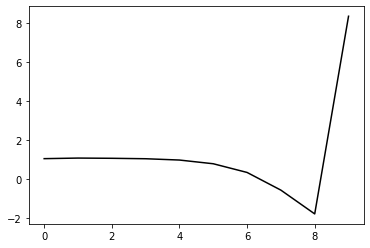

88000 0.21682324604260242
0.273526511104273 -0.16060588876614385 -0.21600278949772753 -0.14614913768636958
[ 1.04422312  1.08557435  1.06724387  1.03353434  0.94982389  0.74776188
  0.30429741 -0.60189322 -1.83154416  8.34854668]


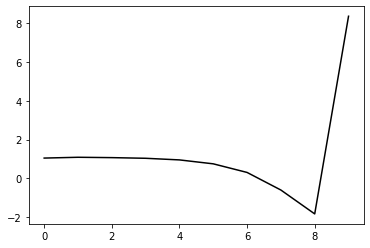

89000 0.20588986239749438
0.2714129866868938 -0.16079713614058144 -0.21649256927845004 -0.14658078964903012
[ 1.045501    1.08754712  1.09269649  1.05914179  0.96302721  0.74888188
  0.30132331 -0.60386038 -1.83970034  8.32522841]


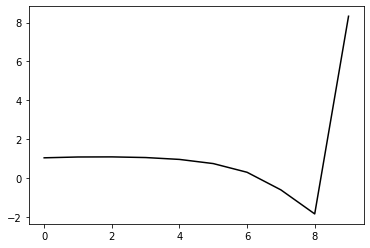

90000 0.23773342889071428
0.27457884150277756 -0.16236896240894966 -0.21854172342714712 -0.1439929604445979
[ 1.06292894  1.12786608  1.12982825  1.09203691  0.98920449  0.76483796
  0.30876464 -0.59509556 -1.82882657  8.35979765]


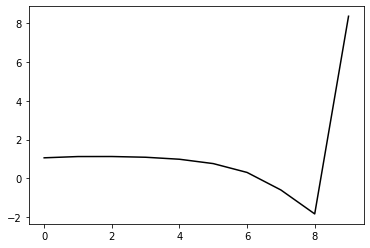

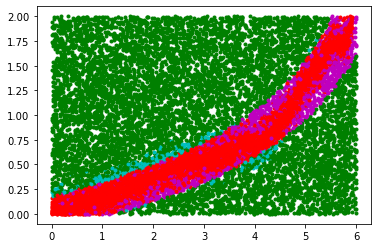

91000 0.15580374909279623
0.27679201091894284 -0.1607891288204692 -0.2177460549080307 -0.1417602033474135
[ 1.07583416  1.1647025   1.18694262  1.15327289  1.0429997   0.80035751
  0.31915387 -0.60673233 -1.86429487  8.32951537]


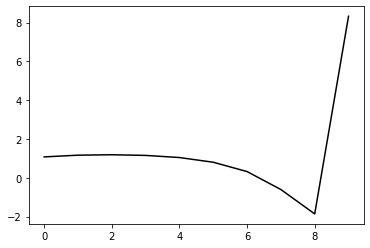

92000 0.17466729097768996
0.27717608113409165 -0.15778953280983238 -0.21710628464345674 -0.13889794756355794
[ 1.05819616  1.18644696  1.20099441  1.16464452  1.06575672  0.8443866
  0.37667427 -0.54207719 -1.79230619  8.36036666]


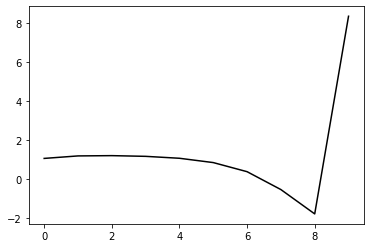

93000 0.2027538681559409
0.2723581624341144 -0.16021658498900423 -0.2172300153689475 -0.14082008973590945
[ 1.0769013   1.16744135  1.16913967  1.14253104  1.04669155  0.82040576
  0.3537641  -0.56228884 -1.80685075  8.35657837]


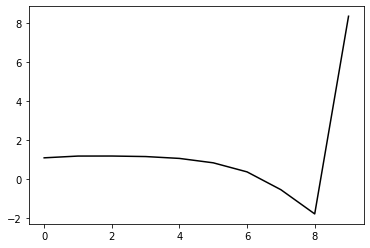

94000 0.15997028049434117
0.27552086182024127 -0.15935715225005842 -0.2165425898123995 -0.14056464134476526
[ 1.07725935  1.093458    1.1101075   1.0739187   0.96054274  0.72112232
  0.24430929 -0.67658176 -1.91904858  8.38701623]


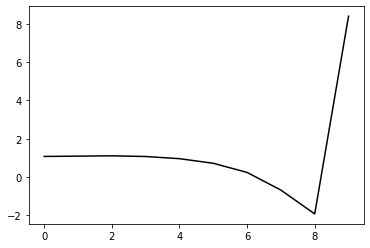

95000 0.2636887691370779
0.27356951639876587 -0.15994415486145255 -0.21673353293311529 -0.1414250459767598
[ 1.06191147  1.09947796  1.10902686  1.07333406  0.95430026  0.70649376
  0.22082107 -0.70671912 -1.95334743  8.3289383 ]


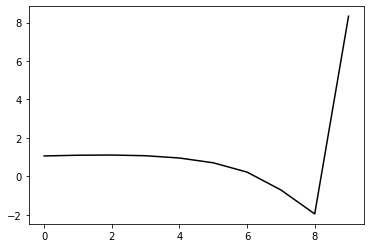

96000 0.17686394049182555
0.2772835586834554 -0.15728125484424127 -0.21597600051015892 -0.14159723850595038
[ 1.04194632  1.15726426  1.16673416  1.12676754  1.01997708  0.78240028
  0.29553468 -0.63843203 -1.89050874  8.37002961]


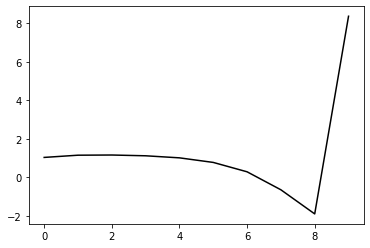

97000 0.19334741247854526
0.2738411870346276 -0.161096371418056 -0.21693355599377317 -0.1390333667563389
[ 1.05595694  1.13451726  1.10598988  1.05333457  0.93725125  0.69300673
  0.20328305 -0.7332144  -1.98191838  8.33799145]


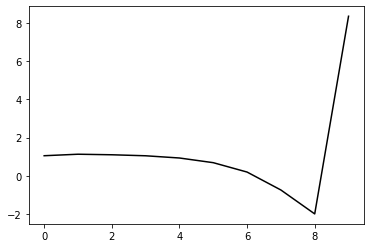

98000 0.18869631090367545
0.27013540869920016 -0.16427926996800024 -0.2199314097635774 -0.1381414135419785
[ 1.06102979  1.0912114   1.06305707  1.04157462  0.96936922  0.76166694
  0.29828702 -0.62044638 -1.85544612  8.34609032]


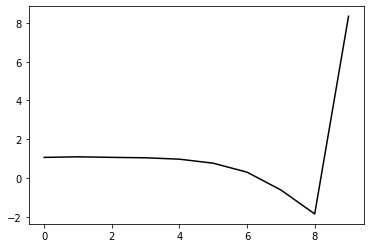

99000 0.2115313143294602
0.2705795719300464 -0.16363641641784843 -0.21814500382707386 -0.14472690889167703
[ 1.05402448  1.10955812  1.11138067  1.08068657  0.99066915  0.77993812
  0.32784849 -0.57885314 -1.80075522  8.35780545]


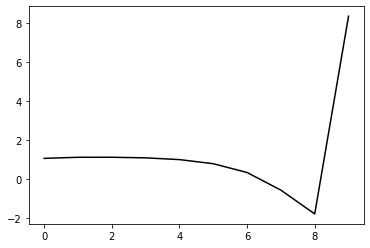

In [44]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()